In [33]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

In [34]:
plant_gen = pd.read_csv('../data/Plant_1_Generation_Data.csv')
plant_weat = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')

# Convert DATR_TIME from string to datetime
plant_gen['DATE_TIME'] = pd.to_datetime(plant_gen['DATE_TIME'])
plant_weat['DATE_TIME'] = pd.to_datetime(plant_weat['DATE_TIME'])

In [35]:
plant_gen['dt'] = plant_gen['DATE_TIME']
plant_weat['dt'] = plant_weat['DATE_TIME']
plant_gen = plant_gen.set_index('DATE_TIME')
plant_weat = plant_weat.set_index('DATE_TIME')

In [36]:
def plot_day_ac_mean_std(d1, d2):
    date = plant_gen[d1:d2]
    df = pd.DataFrame(columns=['Datetime', 'MeanAC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['AC_POWER'].mean(), gp['AC_POWER'].std()]
        i+=1
    plt.figure(figsize=(20, 10))
    for key in date['SOURCE_KEY'].unique():
        plt.plot(date[date['SOURCE_KEY'] == key].index, date[date['SOURCE_KEY'] == key]['AC_POWER'], 'o', color='black')

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    plt.plot(df['Datetime'], df['MeanAC'], color='red')
    plt.plot(df['Datetime'], df['MeanAC'] + 3 * df['std'], color='blue')
    plt.plot(df['Datetime'], df['MeanAC'] - 3 * df['std'], color='green')
    plt.show()

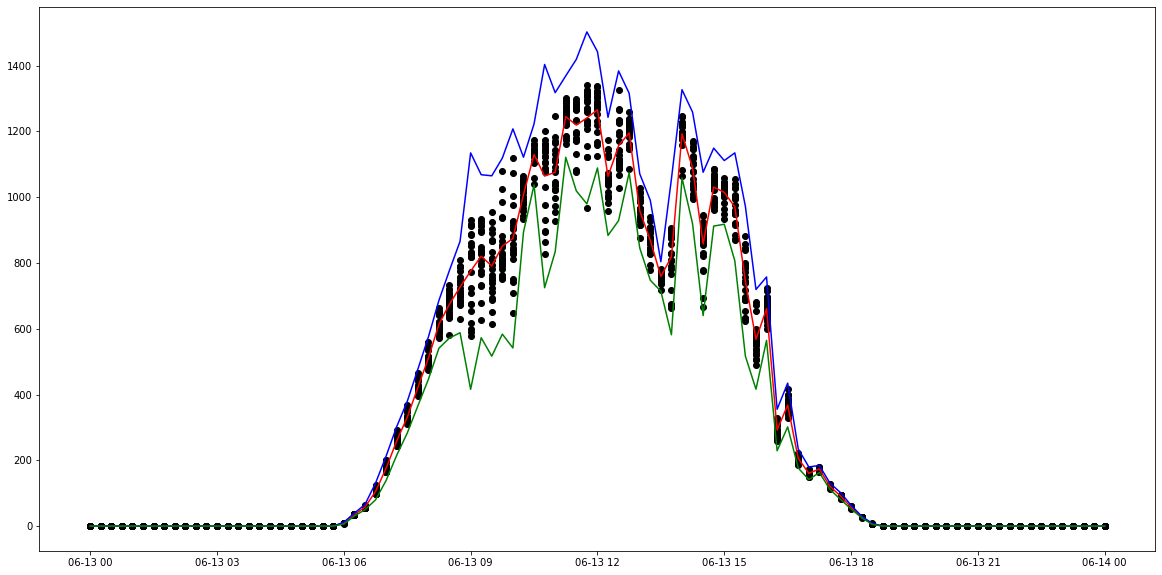

In [37]:
plot_day_ac_mean_std('2020-06-13 00:00:00', '2020-06-14 00:00:00')

In [39]:
def find_outliers_ac(d1, d2, th=3):
    date = plant_gen[d1:d2] # get the data associated to d1:d2
    
    # df is going to b a dataframe which will contain MeanAC, std for each DATE_TIME
    df = pd.DataFrame(columns=['DATE_TIME', 'MeanAC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['AC_POWER'].mean(), gp['AC_POWER'].std()]
        i+=1
    # df is ready
    
    # a list to store all outlier inverters
    l = {}
    
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    df.set_index('DATE_TIME', inplace=True)
    
    for key in date['SOURCE_KEY'].unique():
        inv_data = date[date['SOURCE_KEY'] == key]
        for d in inv_data.index:
            MeanAC = df[df.index == d]['MeanAC'][0]
            std = df[df.index == d]['std'][0]
            AC_POWER = inv_data[inv_data.index == d]['AC_POWER'][0]
            
            if AC_POWER > 0 and (MeanAC-th*std>=AC_POWER or MeanAC+th*std<=AC_POWER):
                if key in l:
                    l[key] += 1
                else:
                    l[key] = 1
    return l

In [40]:
out_invs = {}
for dayofyear in plant_gen['dt'].dt.dayofyear.unique():
    d = datetime(2020, 1, 1) + timedelta(int(dayofyear) - 1)
    year = d.year
    month = d.month if d.month > 9 else '0' + str(d.month)
    day = d.day if d.day > 9 else '0' + str(d.day)
    try:
        invs = find_outliers_ac(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 23:59:00')
        for k in invs.keys():
            if k in out_invs:
                out_invs[k]+=invs[k]
            else:
                out_invs[k] =invs[k]
        print(f'{year}-{month}-{day}', invs)
    except Exception as e:
        print(f'{year}-{month}-{day} 00:00:00', e)

2020-05-15 {'VHMLBKoKgIrUVDU': 1, 'z9Y9gH1T5YWrNuG': 1, 'YxYtjZvoooNbGkE': 1}
2020-05-16 {}
2020-05-17 {'1BY6WEcLGh8j5v7': 2, 'adLQvlD726eNBSB': 1}
2020-05-18 {'ZnxXDlPa8U1GXgE': 1, 'adLQvlD726eNBSB': 1, 'rGa61gmuvPhdLxV': 1}
2020-05-19 {}
2020-05-20 {'ZnxXDlPa8U1GXgE': 1, 'bvBOhCH3iADSZry': 6}
2020-05-21 {}
2020-05-22 {'McdE0feGgRqW7Ca': 1, 'rGa61gmuvPhdLxV': 10}
2020-05-23 {'1BY6WEcLGh8j5v7': 1, 'rGa61gmuvPhdLxV': 6, 'uHbuxQJl8lW7ozc': 1}
2020-05-24 {'uHbuxQJl8lW7ozc': 1, 'zBIq5rxdHJRwDNY': 1}
2020-05-25 {'ZnxXDlPa8U1GXgE': 1, 'ih0vzX44oOqAx2f': 2}
2020-05-26 {}
2020-05-27 {}
2020-05-28 {'1BY6WEcLGh8j5v7': 1}
2020-05-29 {}
2020-05-30 {'bvBOhCH3iADSZry': 4}
2020-05-31 {'adLQvlD726eNBSB': 1, 'bvBOhCH3iADSZry': 3}
2020-06-01 {'bvBOhCH3iADSZry': 1}
2020-06-02 {'bvBOhCH3iADSZry': 2}
2020-06-03 {'bvBOhCH3iADSZry': 1}
2020-06-04 {}
2020-06-05 {'uHbuxQJl8lW7ozc': 1}
2020-06-06 {}
2020-06-07 {'uHbuxQJl8lW7ozc': 1}
2020-06-08 {'1BY6WEcLGh8j5v7': 1}
2020-06-09 {'1BY6WEcLGh8j5v7': 1}
2020-06-10 

In [41]:
out_invs

{'VHMLBKoKgIrUVDU': 1,
 'z9Y9gH1T5YWrNuG': 1,
 'YxYtjZvoooNbGkE': 1,
 '1BY6WEcLGh8j5v7': 8,
 'adLQvlD726eNBSB': 5,
 'ZnxXDlPa8U1GXgE': 3,
 'rGa61gmuvPhdLxV': 17,
 'bvBOhCH3iADSZry': 29,
 'McdE0feGgRqW7Ca': 1,
 'uHbuxQJl8lW7ozc': 4,
 'zBIq5rxdHJRwDNY': 2,
 'ih0vzX44oOqAx2f': 2,
 '3PZuoBAID5Wc2HD': 1,
 'WRmjgnKYAwPKWDb': 1}

In [56]:
def plot_day_dc_mean_std(d1, d2):
    date = plant_gen[d1:d2]
    df = pd.DataFrame(columns=['Datetime', 'MeanDC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['DC_POWER'].mean(), gp['DC_POWER'].std()]
        i+=1
    plt.figure(figsize=(20, 10))
    for key in date['SOURCE_KEY'].unique():
        plt.plot(date[date['SOURCE_KEY'] == key].index, date[date['SOURCE_KEY'] == key]['DC_POWER'], 'o', color='black')

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    plt.plot(df['Datetime'], df['MeanDC'], color='red')
    plt.plot(df['Datetime'], df['MeanDC'] + 3 * df['std'], color='blue')
    plt.plot(df['Datetime'], df['MeanDC'] - 3 * df['std'], color='green')
    plt.show()

In [176]:
def find_outliers_dc(d1, d2, th=3):
    date = plant_gen[d1:d2] # get the data associated to d1:d2
    
    # df is going to b a dataframe which will contain MeanAC, std for each DATE_TIME
    df = pd.DataFrame(columns=['DATE_TIME', 'MeanDC', 'std'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['DC_POWER'].mean(), gp['DC_POWER'].std()]
        i+=1
    # df is ready
    
    # a list to store all outlier inverters
    l = {}
    
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    df.set_index('DATE_TIME', inplace=True)
    
    for key in date['SOURCE_KEY'].unique():
        inv_data = date[date['SOURCE_KEY'] == key]
        for d in inv_data.index:
            MeanAC = df[df.index == d]['MeanDC'][0]
            std = df[df.index == d]['std'][0]
            DC_POWER = inv_data[inv_data.index == d]['DC_POWER'][0]
            
            if DC_POWER > 0 and (MeanAC-th*std>=DC_POWER or MeanAC+th*std<=DC_POWER):
                if key in l:
                    l[key] += 1
                else:
                    l[key] = 1
    return l

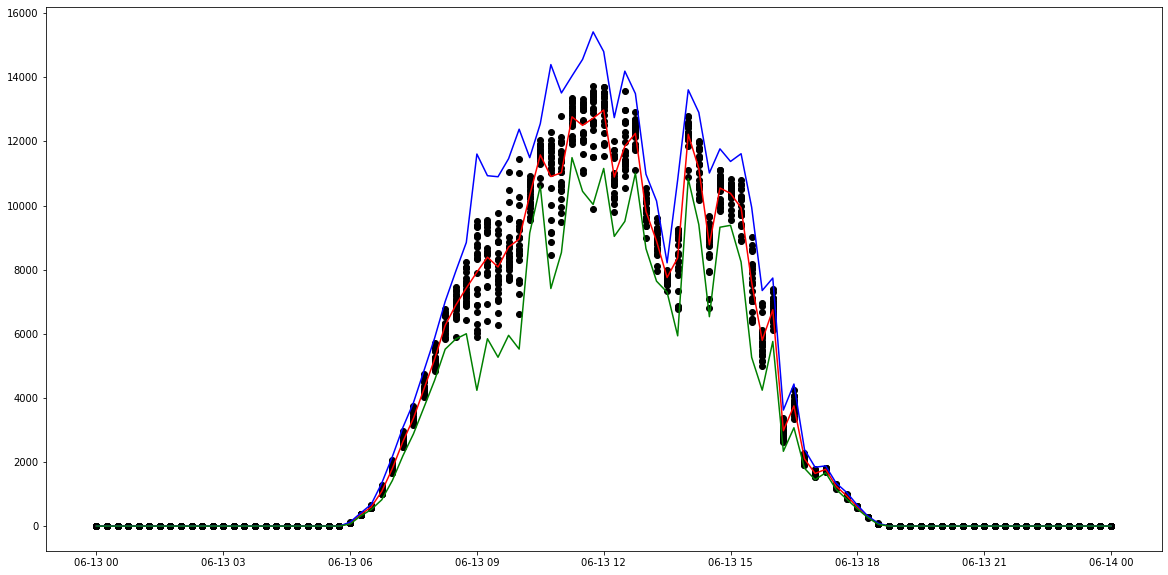

In [44]:
plot_day_dc_mean_std('2020-06-13 00:00:00', '2020-06-14 00:00:00')

In [47]:
out_dc_invs = {}
for dayofyear in plant_gen['dt'].dt.dayofyear.unique():
    d = datetime(2020, 1, 1) + timedelta(int(dayofyear) - 1)
    year = d.year
    month = d.month if d.month > 9 else '0' + str(d.month)
    day = d.day if d.day > 9 else '0' + str(d.day)
    try:
        invs = find_outliers_dc(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 23:59:00')
        for k in invs.keys():
            if k in out_dc_invs:
                out_dc_invs[k]+=invs[k]
            else:
                out_dc_invs[k] =invs[k]
        print(f'{year}-{month}-{day}', invs)
    except Exception as e:
        print(f'{year}-{month}-{day} 00:00:00', e)

2020-05-15 {'VHMLBKoKgIrUVDU': 1, 'z9Y9gH1T5YWrNuG': 1, 'YxYtjZvoooNbGkE': 1}
2020-05-16 {}
2020-05-17 {'1BY6WEcLGh8j5v7': 2, 'adLQvlD726eNBSB': 1}
2020-05-18 {'ZnxXDlPa8U1GXgE': 1, 'adLQvlD726eNBSB': 1, 'rGa61gmuvPhdLxV': 1}
2020-05-19 {}
2020-05-20 {'ZnxXDlPa8U1GXgE': 1, 'bvBOhCH3iADSZry': 6}
2020-05-21 {}
2020-05-22 {'McdE0feGgRqW7Ca': 1, 'rGa61gmuvPhdLxV': 10}
2020-05-23 {'1BY6WEcLGh8j5v7': 1, 'rGa61gmuvPhdLxV': 6, 'uHbuxQJl8lW7ozc': 1}
2020-05-24 {'uHbuxQJl8lW7ozc': 1, 'zBIq5rxdHJRwDNY': 1}
2020-05-25 {'ZnxXDlPa8U1GXgE': 1, 'ih0vzX44oOqAx2f': 2}
2020-05-26 {}
2020-05-27 {}
2020-05-28 {'1BY6WEcLGh8j5v7': 1}
2020-05-29 {}
2020-05-30 {'bvBOhCH3iADSZry': 4}
2020-05-31 {'adLQvlD726eNBSB': 1, 'bvBOhCH3iADSZry': 3}
2020-06-01 {'bvBOhCH3iADSZry': 1}
2020-06-02 {'bvBOhCH3iADSZry': 2}
2020-06-03 {'bvBOhCH3iADSZry': 1}
2020-06-04 {}
2020-06-05 {'uHbuxQJl8lW7ozc': 1}
2020-06-06 {}
2020-06-07 {'uHbuxQJl8lW7ozc': 1}
2020-06-08 {'1BY6WEcLGh8j5v7': 1}
2020-06-09 {'1BY6WEcLGh8j5v7': 1}
2020-06-10 

In [49]:
out_dc_invs, out_invs # it looks like there is no difference between AC/DC in terms of outliers 

({'VHMLBKoKgIrUVDU': 1,
  'z9Y9gH1T5YWrNuG': 1,
  'YxYtjZvoooNbGkE': 1,
  '1BY6WEcLGh8j5v7': 8,
  'adLQvlD726eNBSB': 5,
  'ZnxXDlPa8U1GXgE': 3,
  'rGa61gmuvPhdLxV': 17,
  'bvBOhCH3iADSZry': 29,
  'McdE0feGgRqW7Ca': 1,
  'uHbuxQJl8lW7ozc': 4,
  'zBIq5rxdHJRwDNY': 2,
  'ih0vzX44oOqAx2f': 2,
  '3PZuoBAID5Wc2HD': 1,
  'WRmjgnKYAwPKWDb': 1},
 {'VHMLBKoKgIrUVDU': 1,
  'z9Y9gH1T5YWrNuG': 1,
  'YxYtjZvoooNbGkE': 1,
  '1BY6WEcLGh8j5v7': 8,
  'adLQvlD726eNBSB': 5,
  'ZnxXDlPa8U1GXgE': 3,
  'rGa61gmuvPhdLxV': 17,
  'bvBOhCH3iADSZry': 29,
  'McdE0feGgRqW7Ca': 1,
  'uHbuxQJl8lW7ozc': 4,
  'zBIq5rxdHJRwDNY': 2,
  'ih0vzX44oOqAx2f': 2,
  '3PZuoBAID5Wc2HD': 1,
  'WRmjgnKYAwPKWDb': 1})

In [23]:
inv1 = plant_gen[plant_gen['SOURCE_KEY'] == 'bvBOhCH3iADSZry']

<ipython-input-187-eb9942f2da6e>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.scatter(plant_gen['2020-06-12'].index, plant_gen['2020-06-12']['DC_POWER'])
<ipython-input-187-eb9942f2da6e>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.scatter(inv1['2020-06-12'].index, inv1['2020-06-12']['DC_POWER'], color='red')


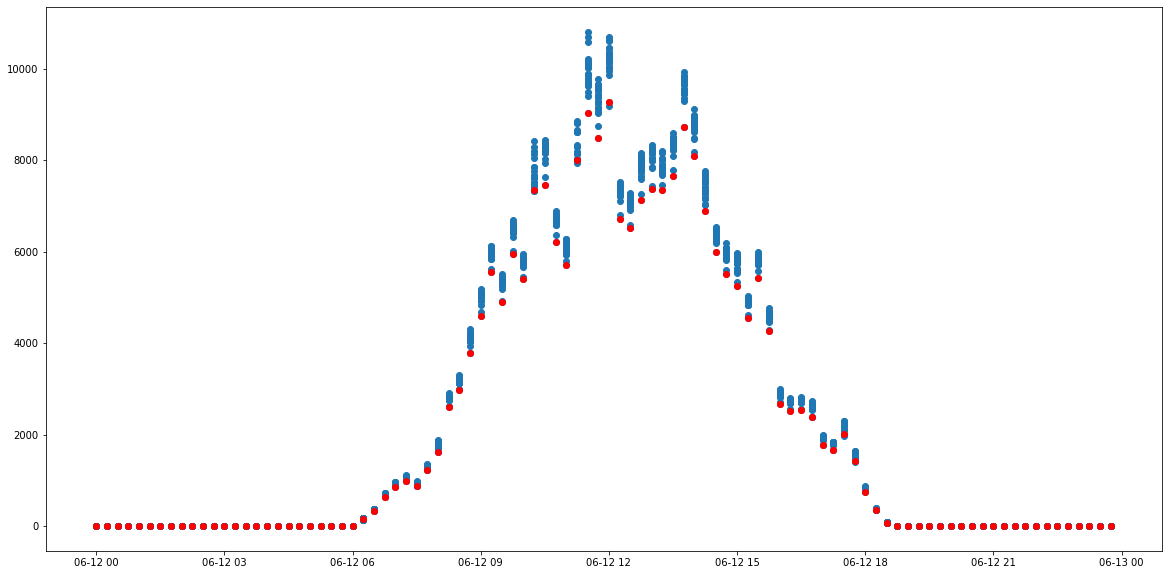

In [187]:
plt.figure(figsize=(20, 10))
plt.scatter(plant_gen['2020-06-12'].index, plant_gen['2020-06-12']['DC_POWER'])
plt.scatter(inv1['2020-06-12'].index, inv1['2020-06-12']['DC_POWER'], color='red')

In [52]:
merged_df = pd.merge(plant_gen, plant_weat, how='inner', on='DATE_TIME')

In [192]:
def plot_dc_irr(d1, d2):
    date = merged_df[d1:d2]
    df = pd.DataFrame(columns=['Datetime', 'MeanDC', 'std', 'IRRADIATION'])
    i = 0
    for _, gp in date.groupby(by=date.index):
        df.loc[i] = [_, gp['DC_POWER'].mean(), gp['DC_POWER'].std(), gp['IRRADIATION'].mean()]
        i+=1
    plt.figure(figsize=(20, 10))
    for key in date['SOURCE_KEY_x'].unique():
        plt.plot(date[date['SOURCE_KEY_x'] == key].index, date[date['SOURCE_KEY_x'] == key]['DC_POWER'], 'o', color='black')
    print(df.corr())
    print("df['MeanDC'] std", df['MeanDC'].std())
    print("df['std'] std", df['std'].std())
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    plt.plot(df['Datetime'], df['MeanDC'], color='red', label='MeanDC')
    plt.plot(df['Datetime'], df['MeanDC'] + 3 * df['std'], color='blue', label='MeanDC + 3std')
    plt.plot(df['Datetime'], df['MeanDC'] - 3 * df['std'], color='green', label='MeanDC - 3std')
    plt.plot(df['Datetime'], df['IRRADIATION'] * 10000, color='m', label='IRRADIATION times 10000')
    plt.title(d1)
    plt.legend()
    plt.show()
    return (df['std']/df['MeanDC']).mean()

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.775176     0.996814
std          0.775176  1.000000     0.777053
IRRADIATION  0.996814  0.777053     1.000000
df['MeanDC'] std 3388.950440766783
df['std'] std 390.6676631710957


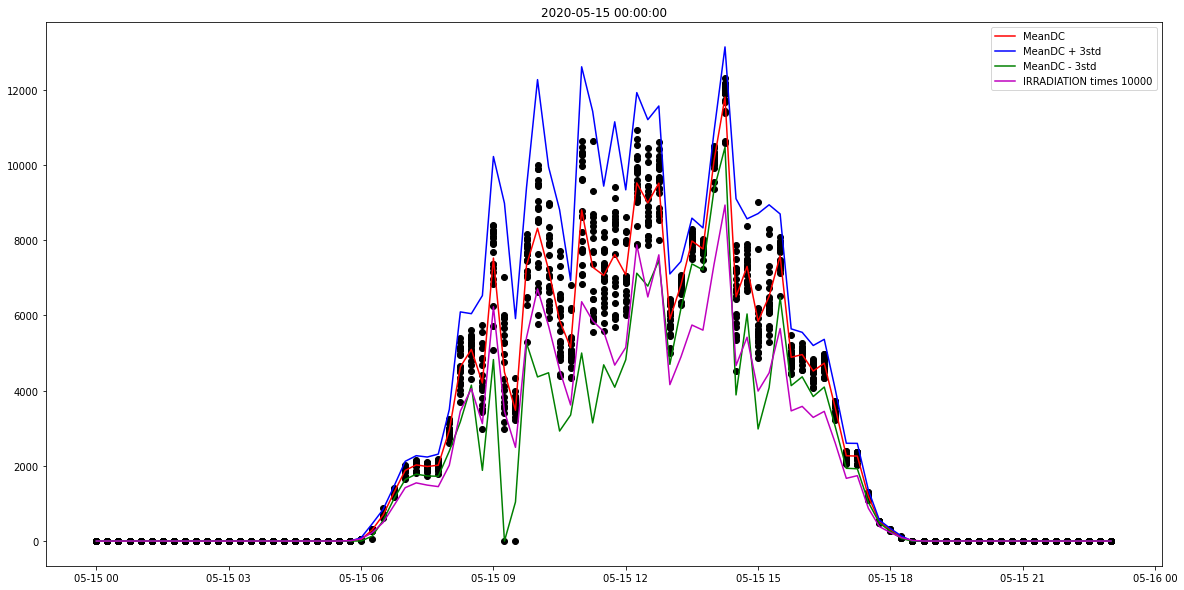

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.915774     0.999354
std          0.915774  1.000000     0.916854
IRRADIATION  0.999354  0.916854     1.000000
df['MeanDC'] std 3553.141696196953
df['std'] std 210.68593956582743


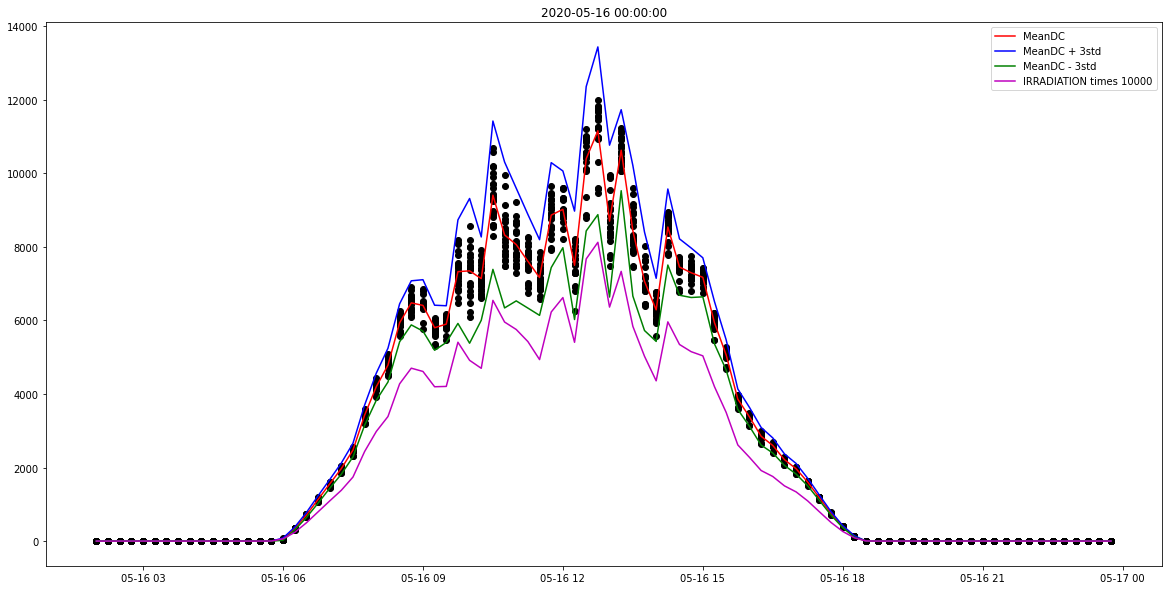

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.846814     0.998046
std          0.846814  1.000000     0.850566
IRRADIATION  0.998046  0.850566     1.000000
df['MeanDC'] std 4096.314675558263
df['std'] std 361.52564037016015


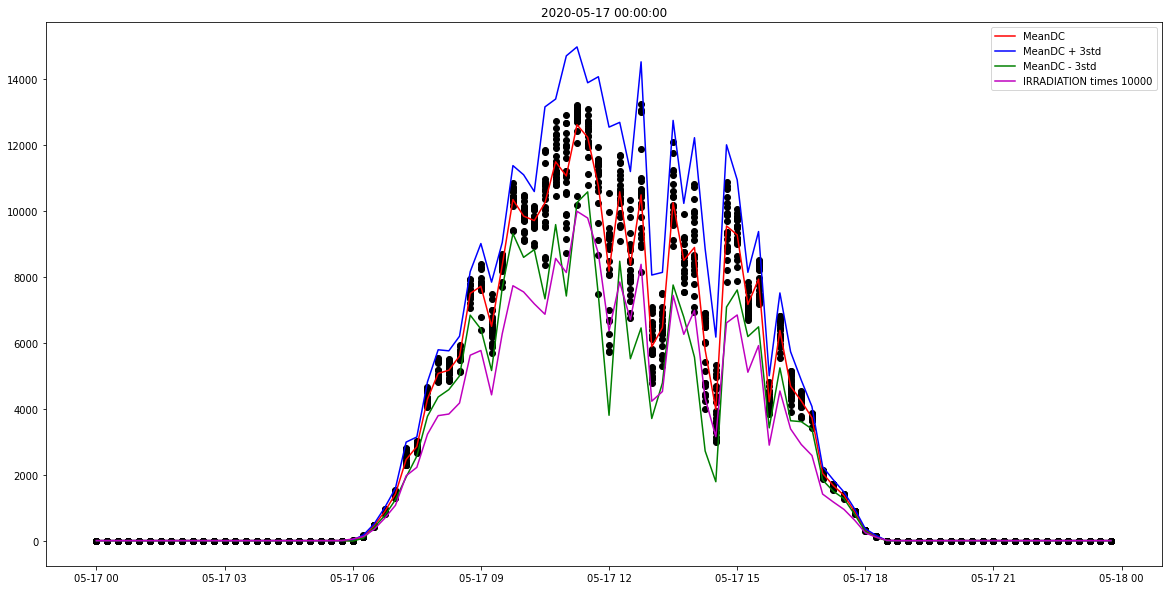

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.968102     0.998950
std          0.968102  1.000000     0.972276
IRRADIATION  0.998950  0.972276     1.000000
df['MeanDC'] std 3249.770329308316
df['std'] std 110.72344951582262


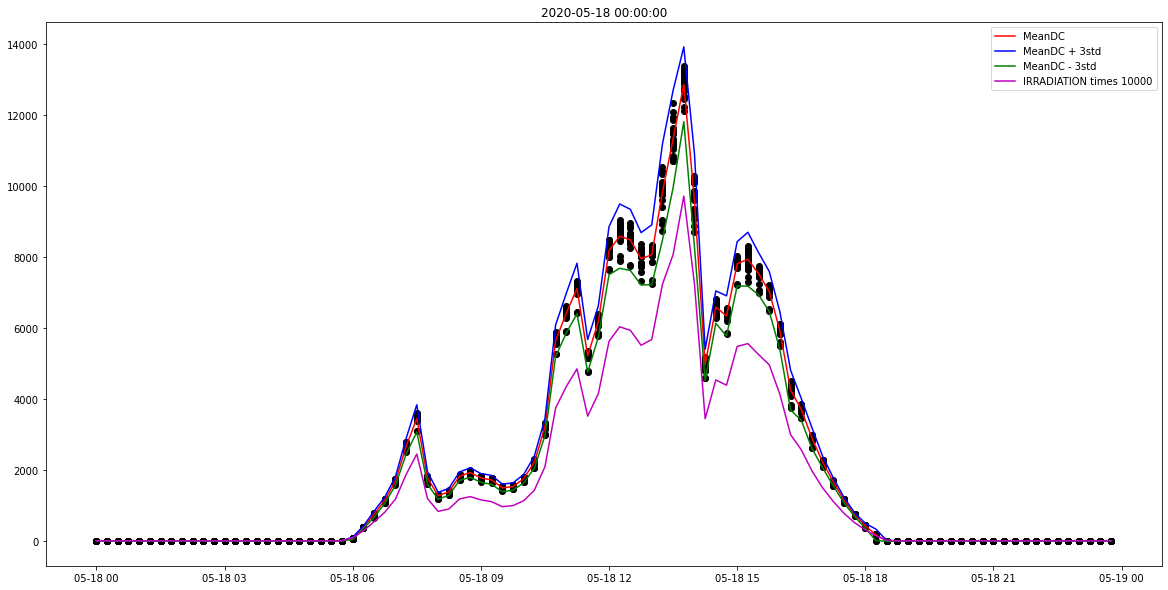

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.873966     0.999078
std          0.873966  1.000000     0.880437
IRRADIATION  0.999078  0.880437     1.000000
df['MeanDC'] std 3586.288940945099
df['std'] std 211.88106048935234


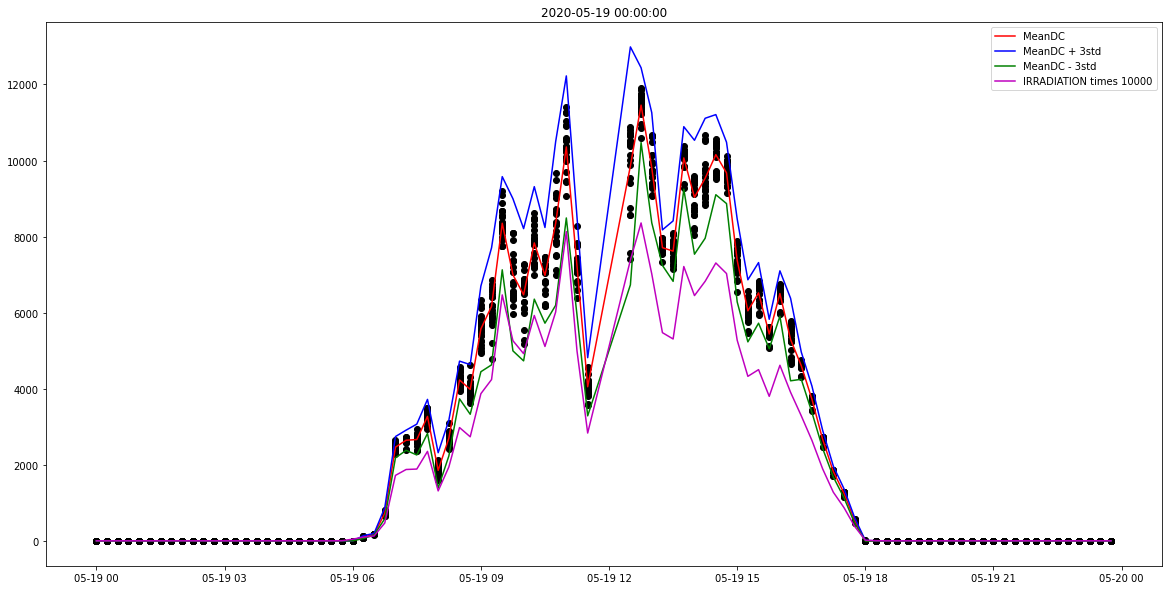

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.972325     0.999771
std          0.972325  1.000000     0.974262
IRRADIATION  0.999771  0.974262     1.000000
df['MeanDC'] std 4761.879155210228
df['std'] std 139.46224155555373


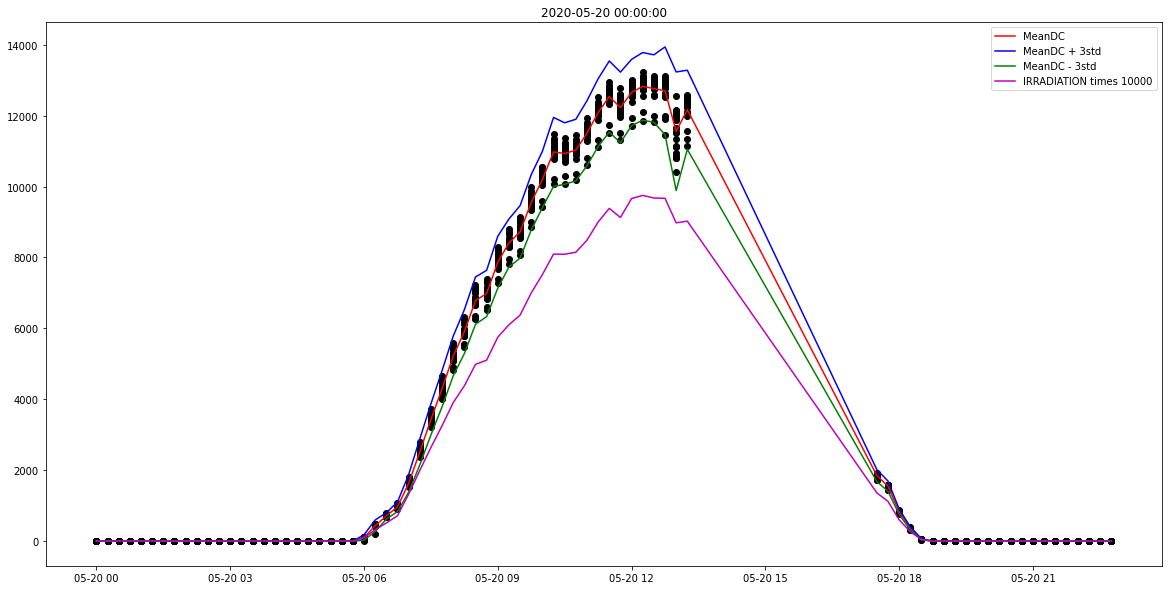

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.835537     0.992986
std          0.835537  1.000000     0.841584
IRRADIATION  0.992986  0.841584     1.000000
df['MeanDC'] std 4593.739799811574
df['std'] std 407.0894175543894


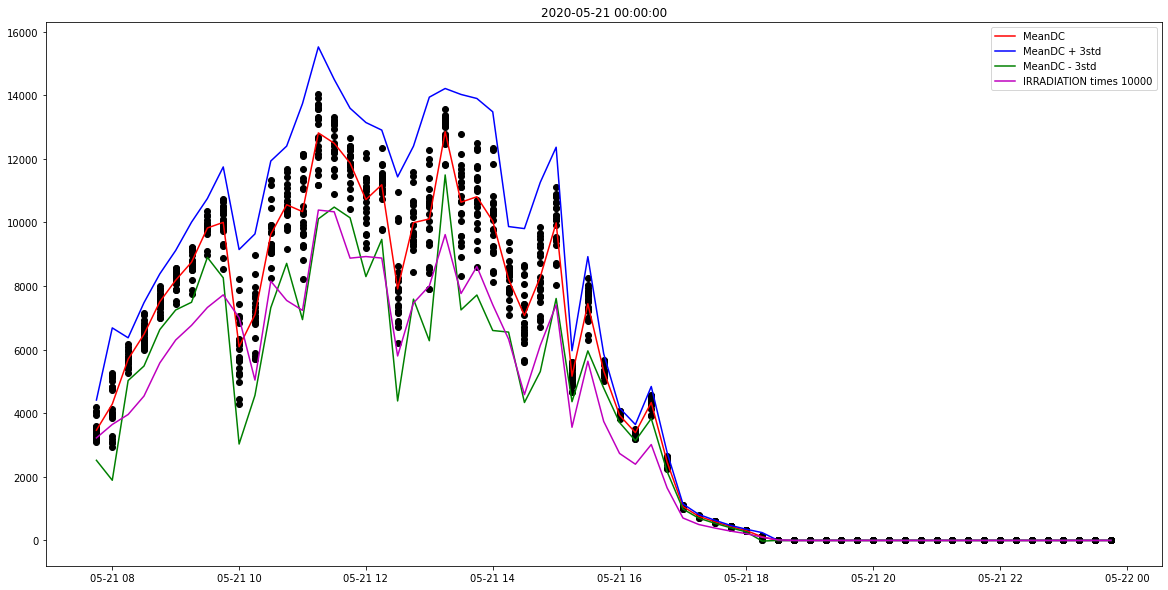

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.784285     0.997665
std          0.784285  1.000000     0.774873
IRRADIATION  0.997665  0.774873     1.000000
df['MeanDC'] std 4073.3157632706425
df['std'] std 419.6995738442563


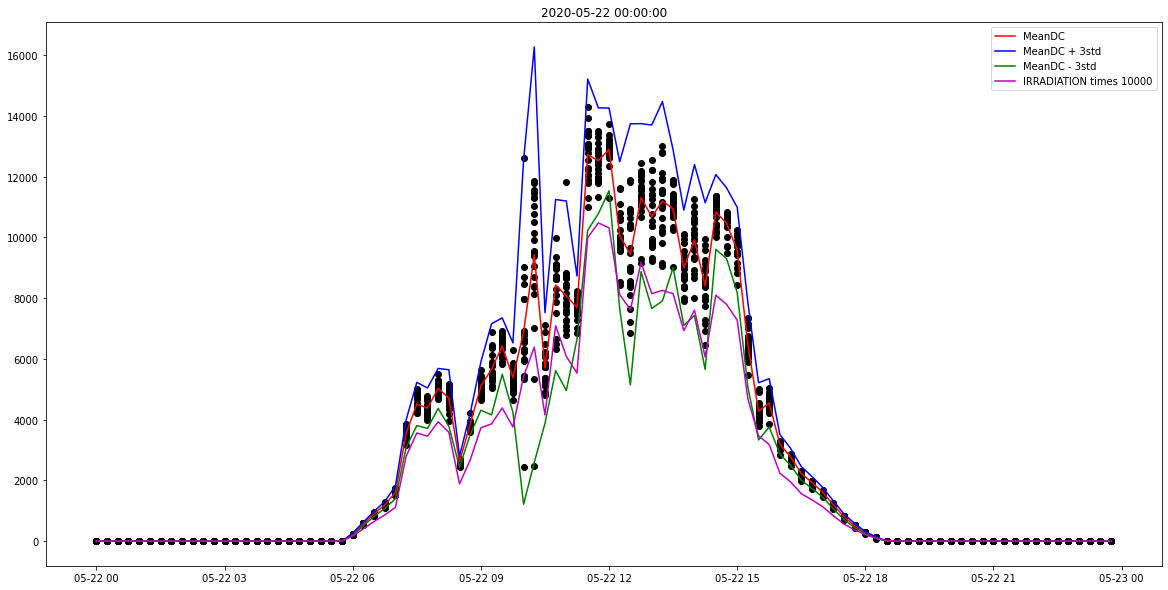

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.776287     0.998006
std          0.776287  1.000000     0.779894
IRRADIATION  0.998006  0.779894     1.000000
df['MeanDC'] std 4588.145608654953
df['std'] std 279.5570762432055


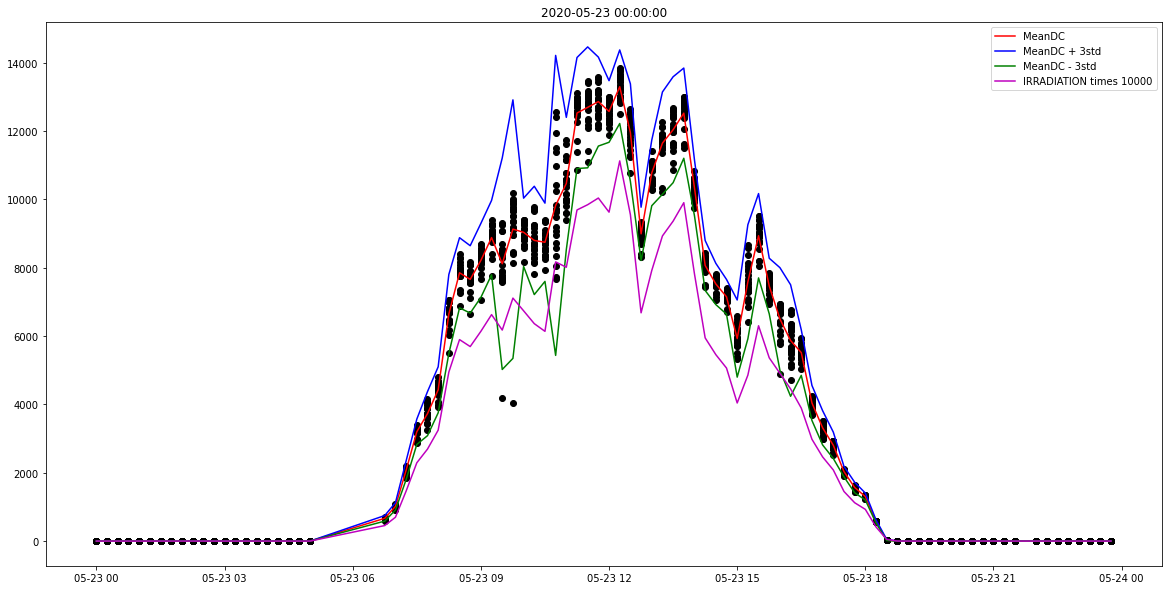

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.802164     0.996406
std          0.802164  1.000000     0.807457
IRRADIATION  0.996406  0.807457     1.000000
df['MeanDC'] std 4355.99081288789
df['std'] std 404.0928559676883


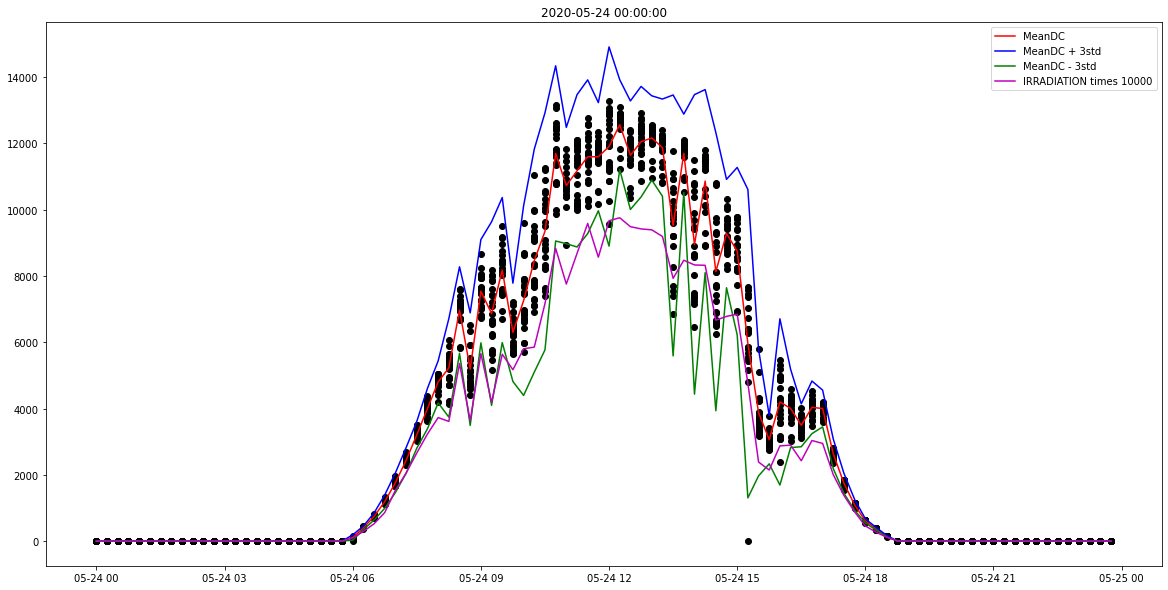

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.684295     0.999267
std          0.684295  1.000000     0.688370
IRRADIATION  0.999267  0.688370     1.000000
df['MeanDC'] std 4897.157088248429
df['std'] std 304.44953871017043


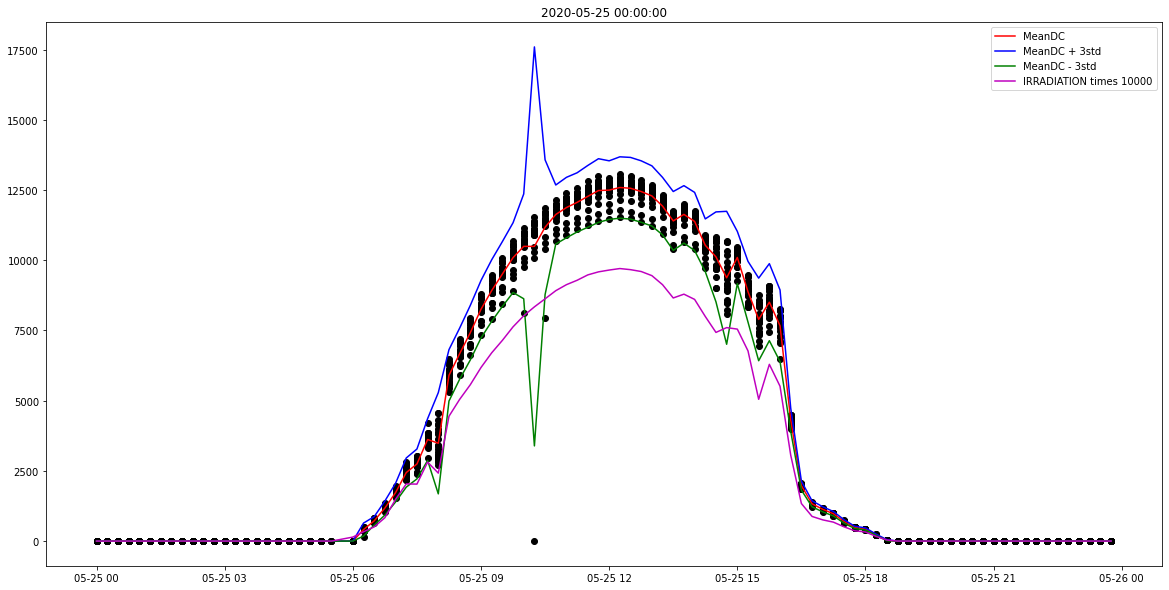

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.831381     0.995786
std          0.831381  1.000000     0.811138
IRRADIATION  0.995786  0.811138     1.000000
df['MeanDC'] std 4249.627647908092
df['std'] std 386.1875582474143


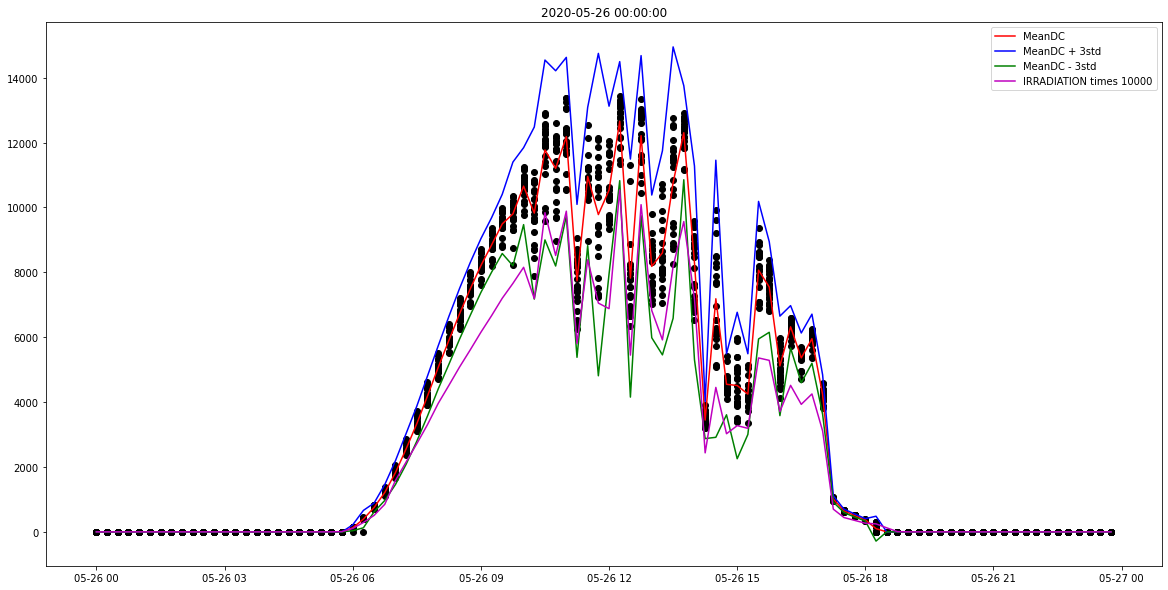

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.884426     0.997221
std          0.884426  1.000000     0.887170
IRRADIATION  0.997221  0.887170     1.000000
df['MeanDC'] std 3590.6573888319767
df['std'] std 388.0476041478144


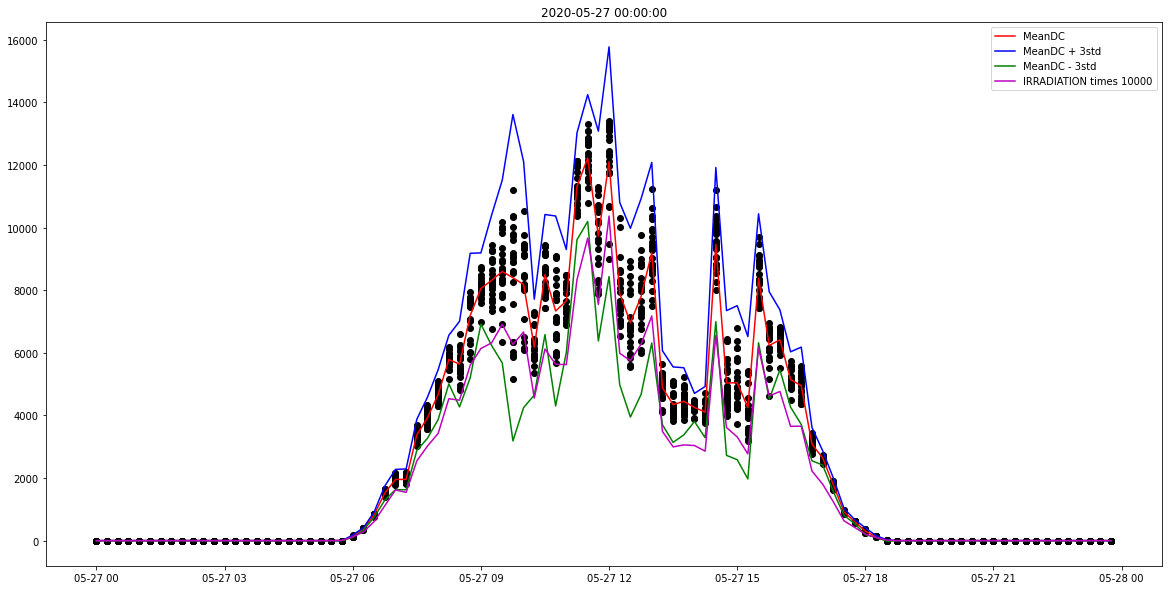

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.820169     0.997973
std          0.820169  1.000000     0.818535
IRRADIATION  0.997973  0.818535     1.000000
df['MeanDC'] std 4558.420343356681
df['std'] std 322.42570716865015


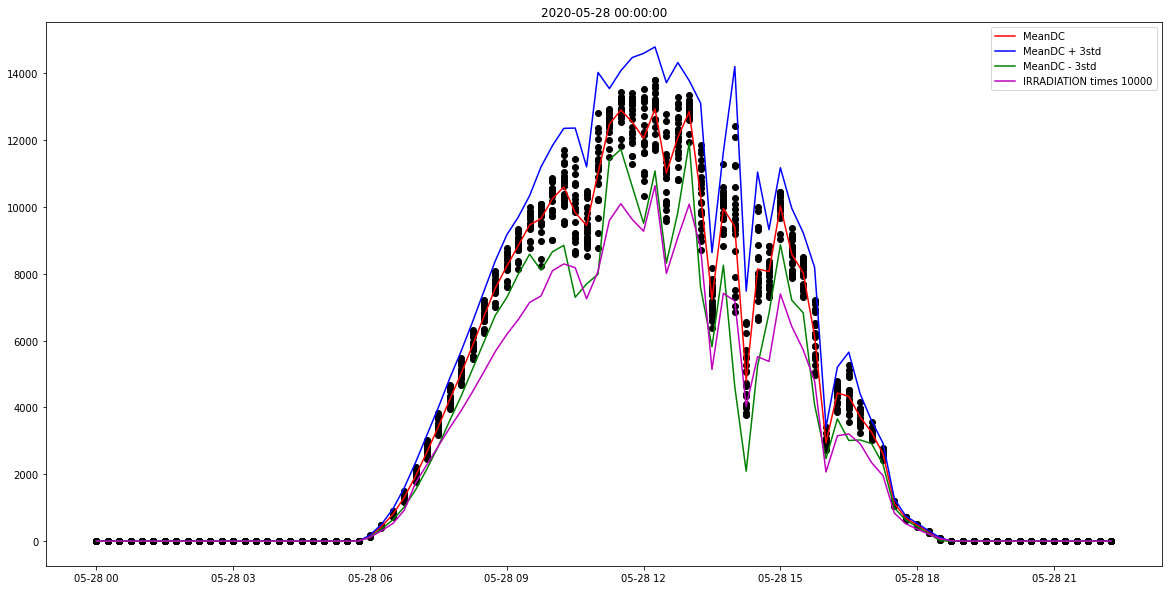

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.776970     0.998107
std          0.776970  1.000000     0.779831
IRRADIATION  0.998107  0.779831     1.000000
df['MeanDC'] std 4565.301001733078
df['std'] std 251.5490663954437


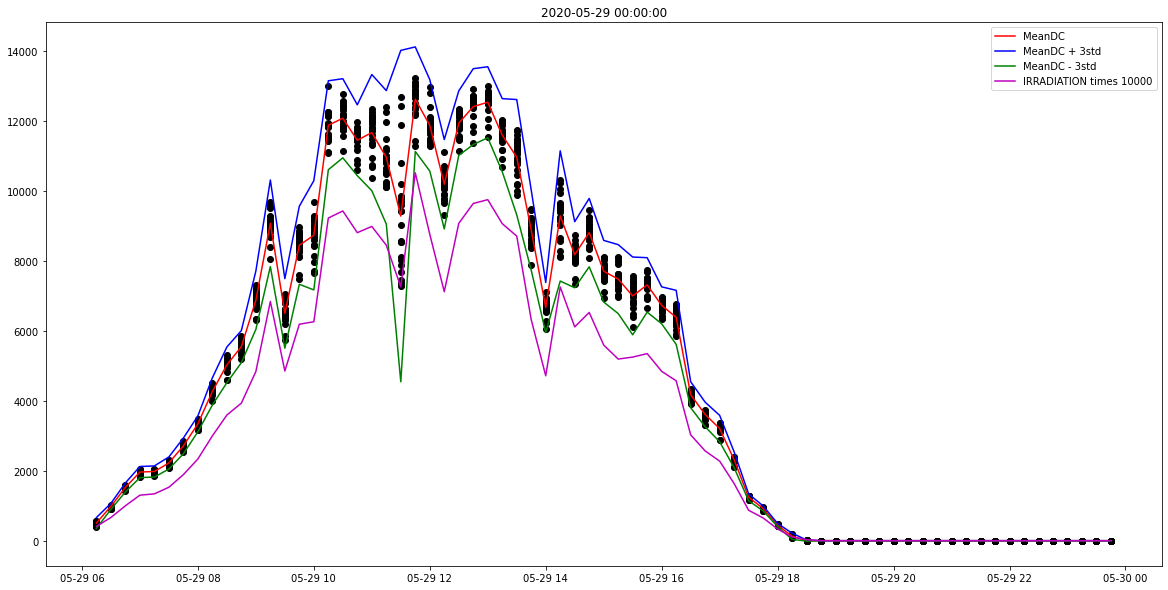

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.931595     0.995814
std          0.931595  1.000000     0.933471
IRRADIATION  0.995814  0.933471     1.000000
df['MeanDC'] std 4060.8584039232387
df['std'] std 162.37951474869018


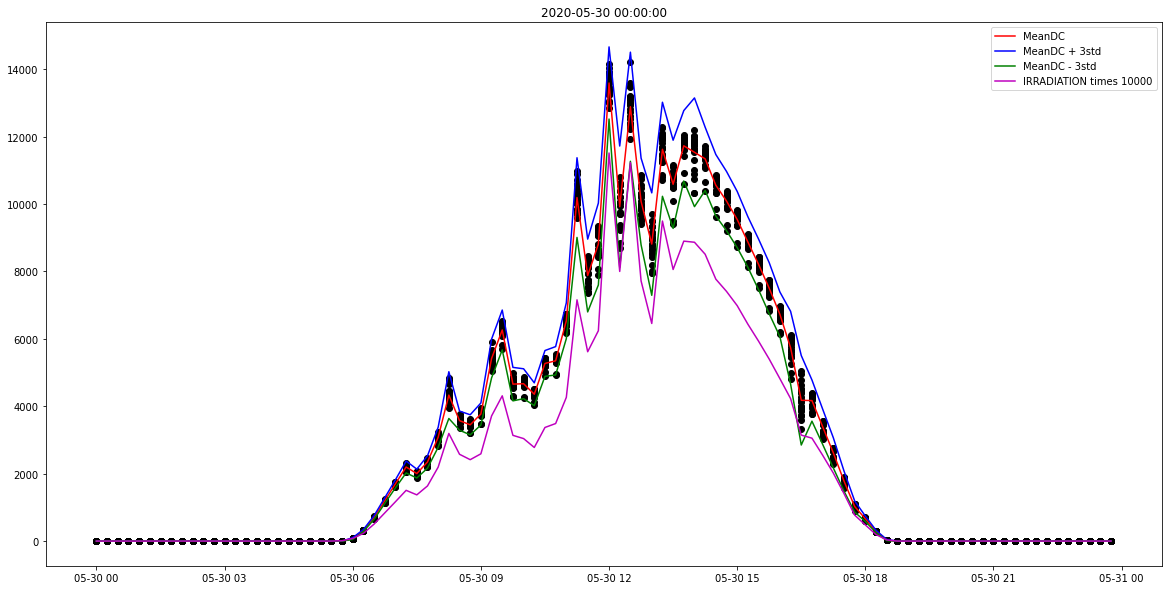

              MeanDC       std  IRRADIATION
MeanDC       1.00000  0.849340     0.994110
std          0.84934  1.000000     0.817287
IRRADIATION  0.99411  0.817287     1.000000
df['MeanDC'] std 3599.69250163633
df['std'] std 473.5992914310799


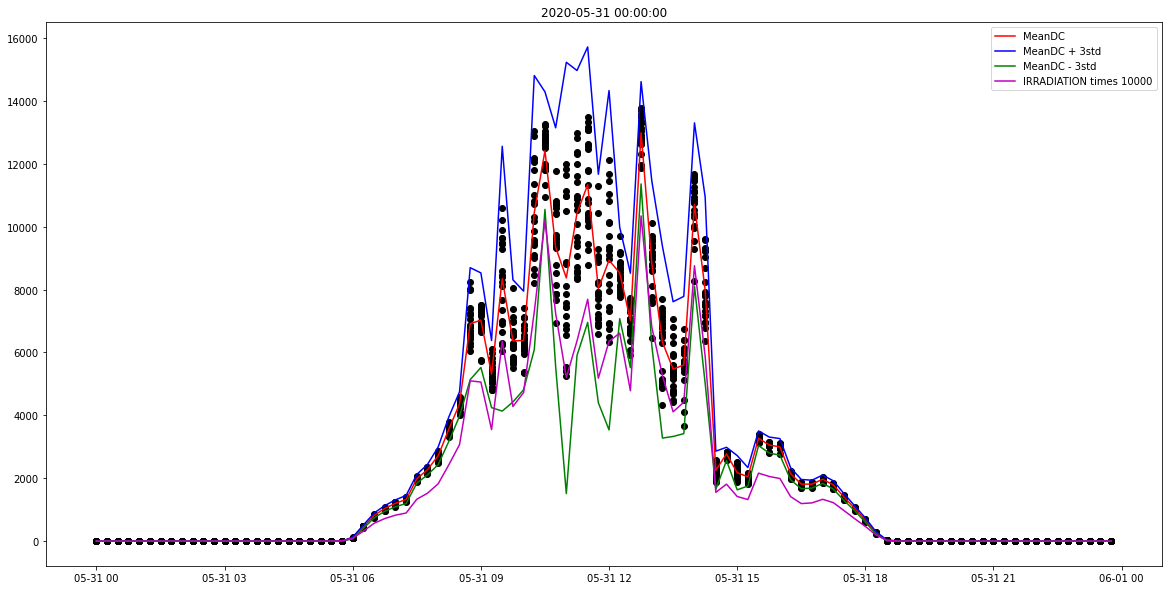

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.845737     0.986472
std          0.845737  1.000000     0.799696
IRRADIATION  0.986472  0.799696     1.000000
df['MeanDC'] std 3430.662471927453
df['std'] std 422.4330307398617


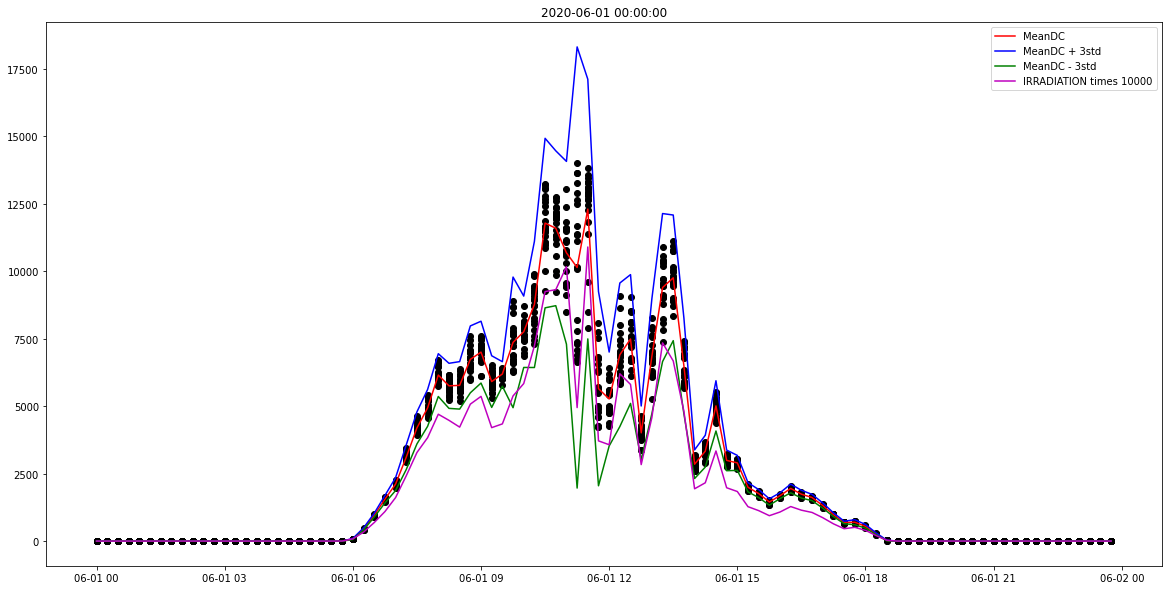

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.838873     0.998865
std          0.838873  1.000000     0.843915
IRRADIATION  0.998865  0.843915     1.000000
df['MeanDC'] std 4000.862617740992
df['std'] std 237.16223187468688


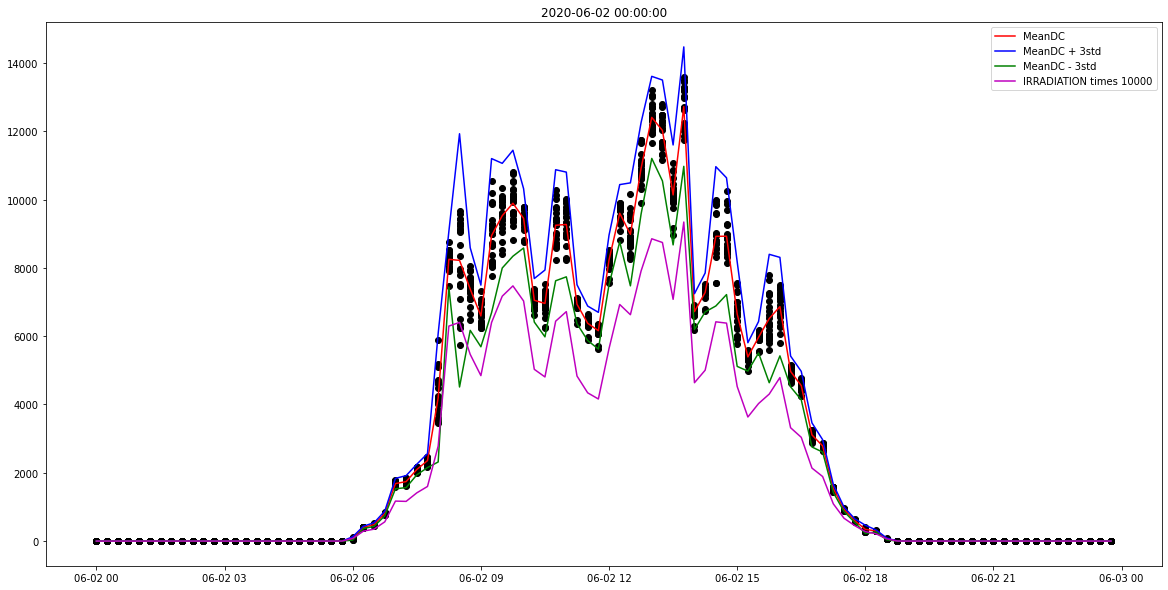

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.882967     0.999084
std          0.882967  1.000000     0.885321
IRRADIATION  0.999084  0.885321     1.000000
df['MeanDC'] std 4149.362462828818
df['std'] std 181.55815585641562


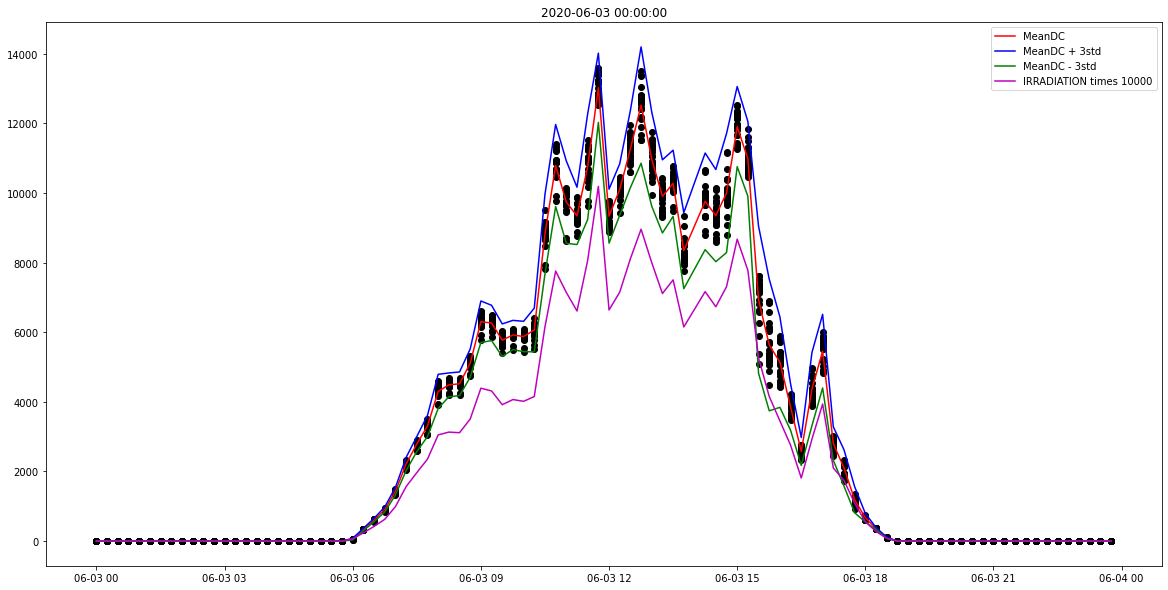

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.875545     0.995933
std          0.875545  1.000000     0.877386
IRRADIATION  0.995933  0.877386     1.000000
df['MeanDC'] std 4233.120664057884
df['std'] std 331.05624839639165


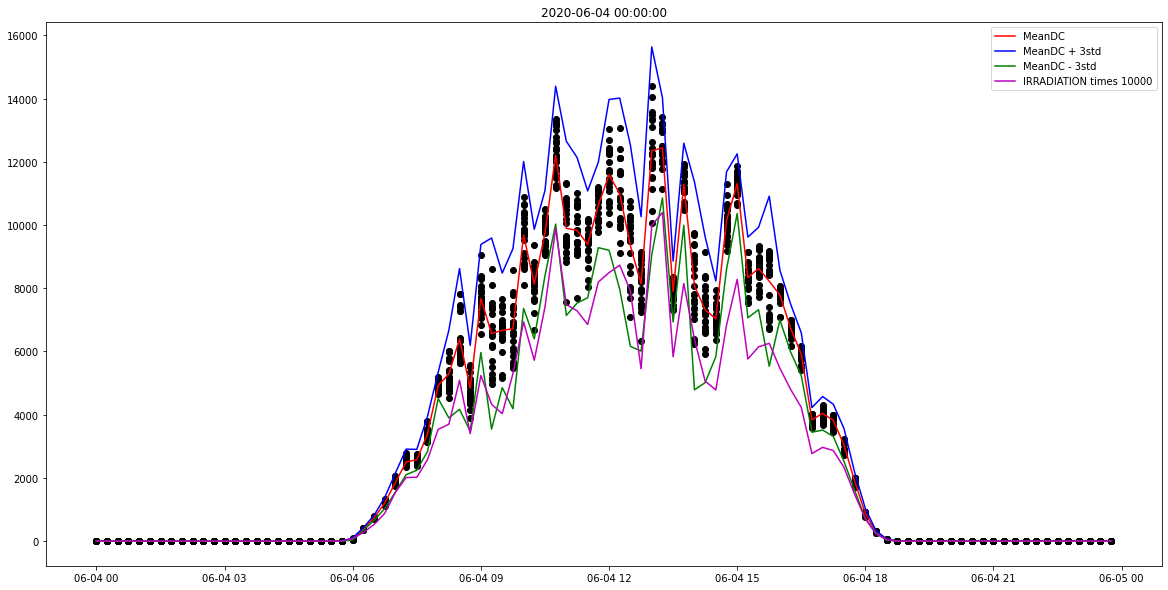

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.830111      0.99618
std          0.830111  1.000000      0.84759
IRRADIATION  0.996180  0.847590      1.00000
df['MeanDC'] std 4104.004814899693
df['std'] std 332.1776625554497


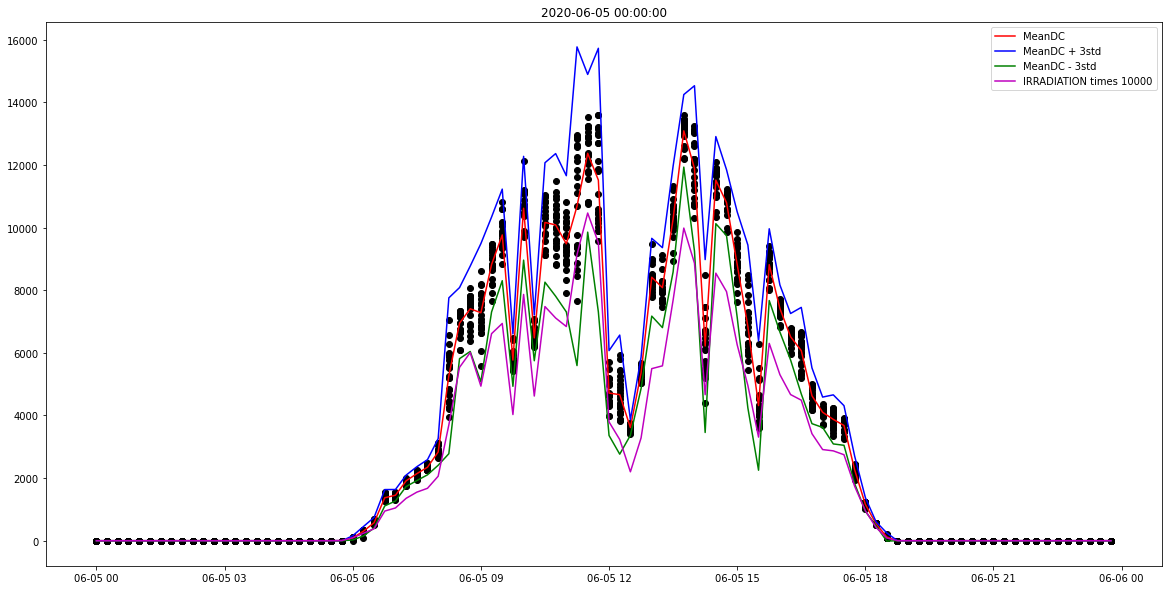

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.898486     0.994202
std          0.898486  1.000000     0.897666
IRRADIATION  0.994202  0.897666     1.000000
df['MeanDC'] std 3701.700569709426
df['std'] std 328.2708683047274


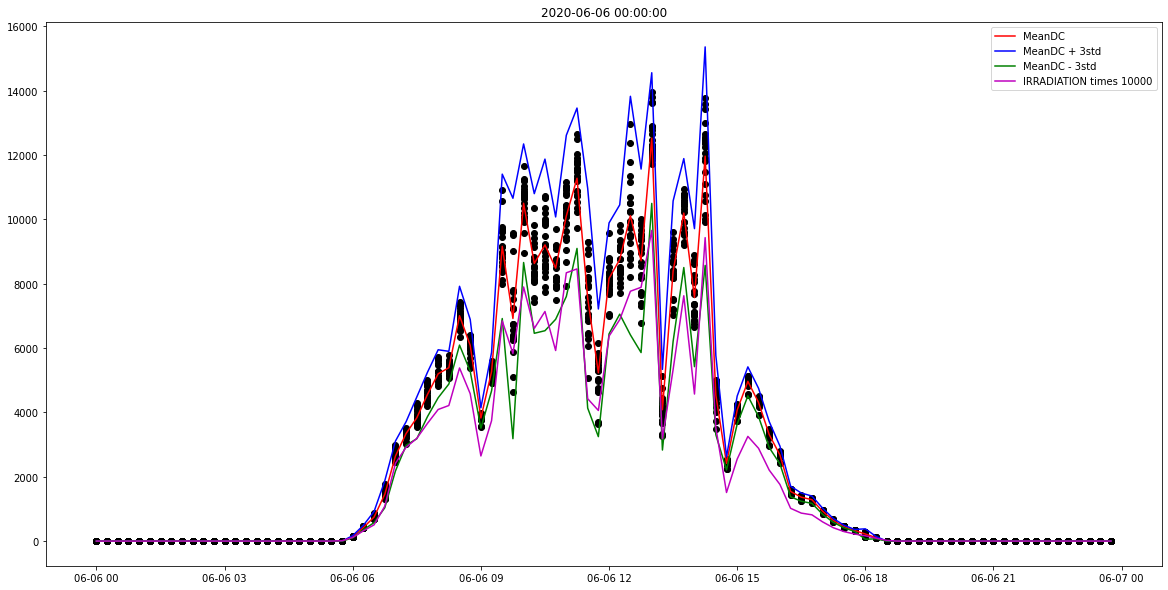

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.530480     0.984711
std          0.530480  1.000000     0.654579
IRRADIATION  0.984711  0.654579     1.000000
df['MeanDC'] std 4178.862218758924
df['std'] std 1344.5711531095553


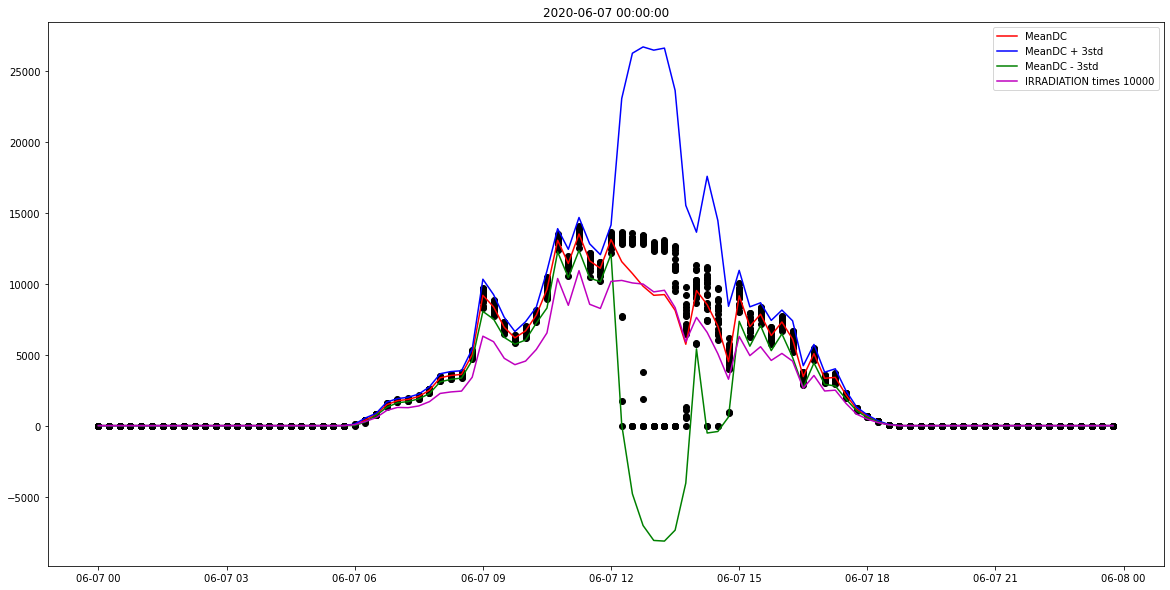

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.891276     0.998441
std          0.891276  1.000000     0.896106
IRRADIATION  0.998441  0.896106     1.000000
df['MeanDC'] std 4442.312661780687
df['std'] std 319.70100241998045


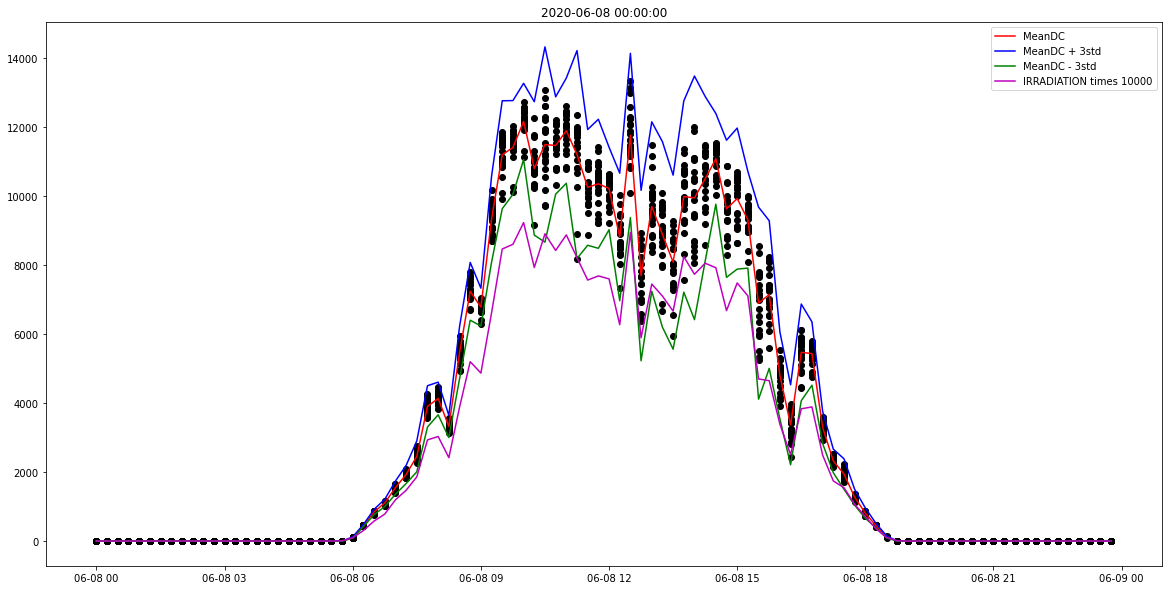

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.853426     0.997829
std          0.853426  1.000000     0.861336
IRRADIATION  0.997829  0.861336     1.000000
df['MeanDC'] std 4191.296268077408
df['std'] std 332.13793628960696


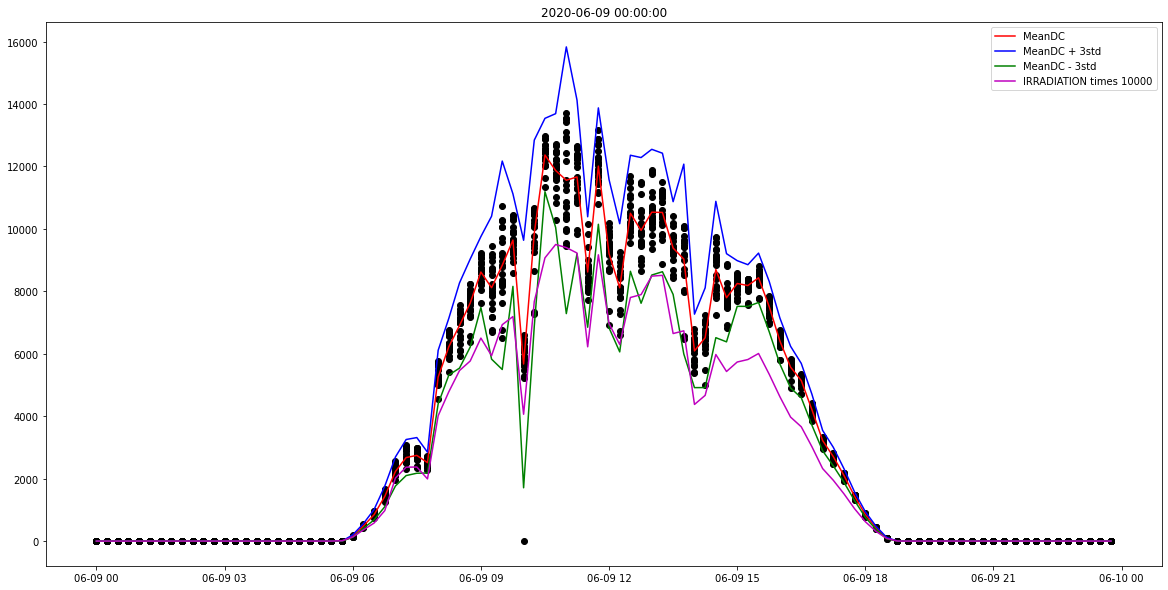

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.873577     0.997300
std          0.873577  1.000000     0.884858
IRRADIATION  0.997300  0.884858     1.000000
df['MeanDC'] std 3638.05465926753
df['std'] std 257.1834246904699


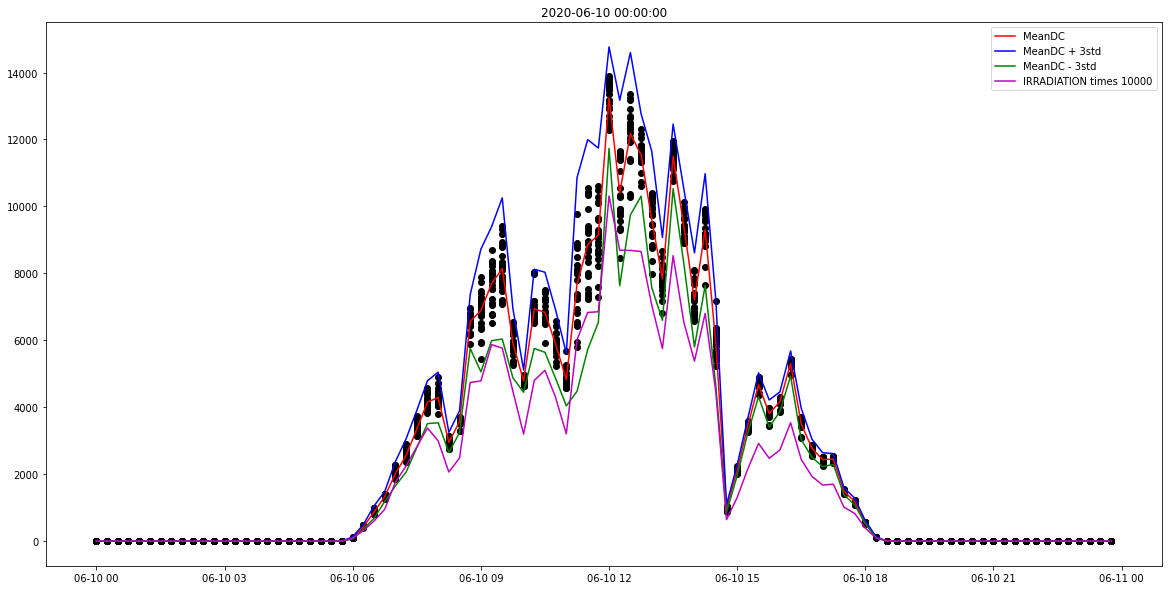

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.930359     0.999513
std          0.930359  1.000000     0.934824
IRRADIATION  0.999513  0.934824     1.000000
df['MeanDC'] std 3078.1934161847994
df['std'] std 116.00852895657455


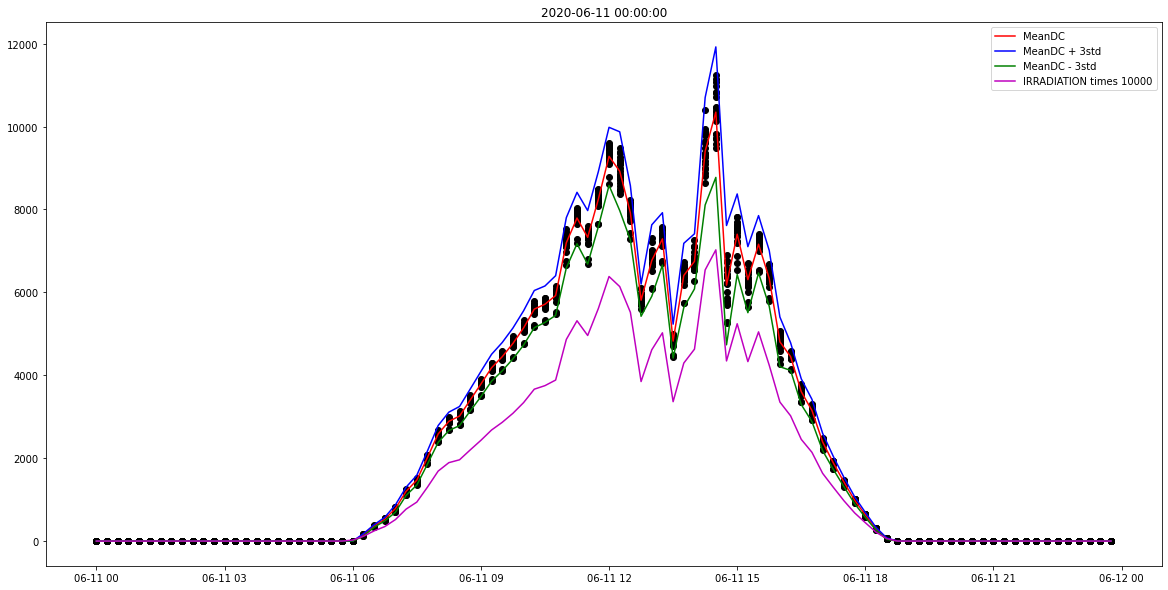

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.973626     0.999491
std          0.973626  1.000000     0.973050
IRRADIATION  0.999491  0.973050     1.000000
df['MeanDC'] std 3247.2039318336324
df['std'] std 103.50614223559083


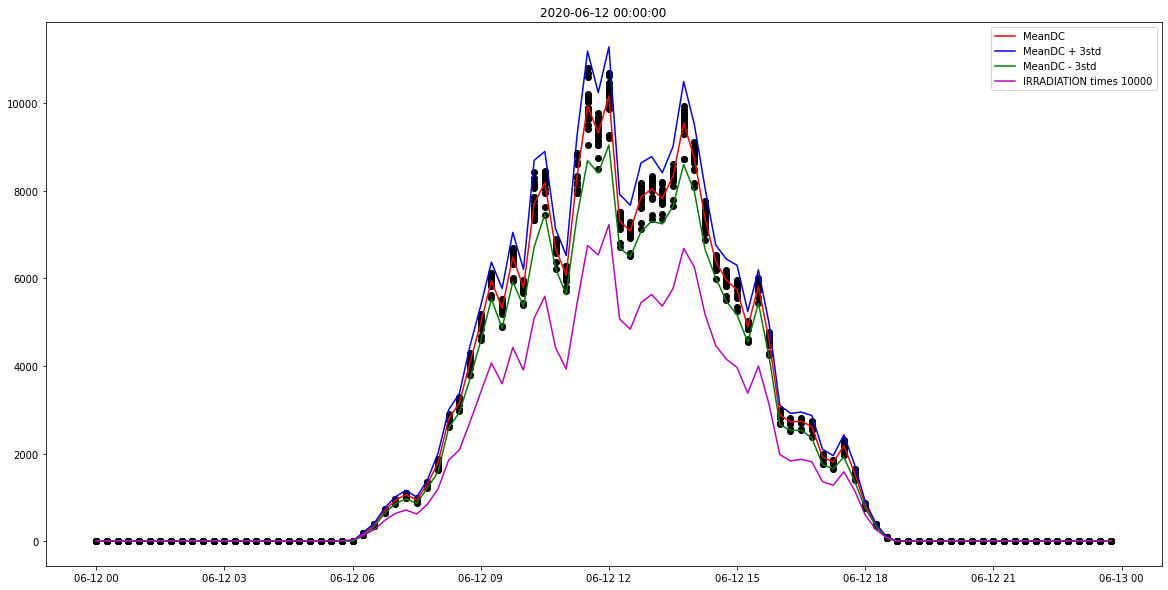

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.846550     0.998146
std          0.846550  1.000000     0.842494
IRRADIATION  0.998146  0.842494     1.000000
df['MeanDC'] std 4599.794735845473
df['std'] std 326.2180285454924


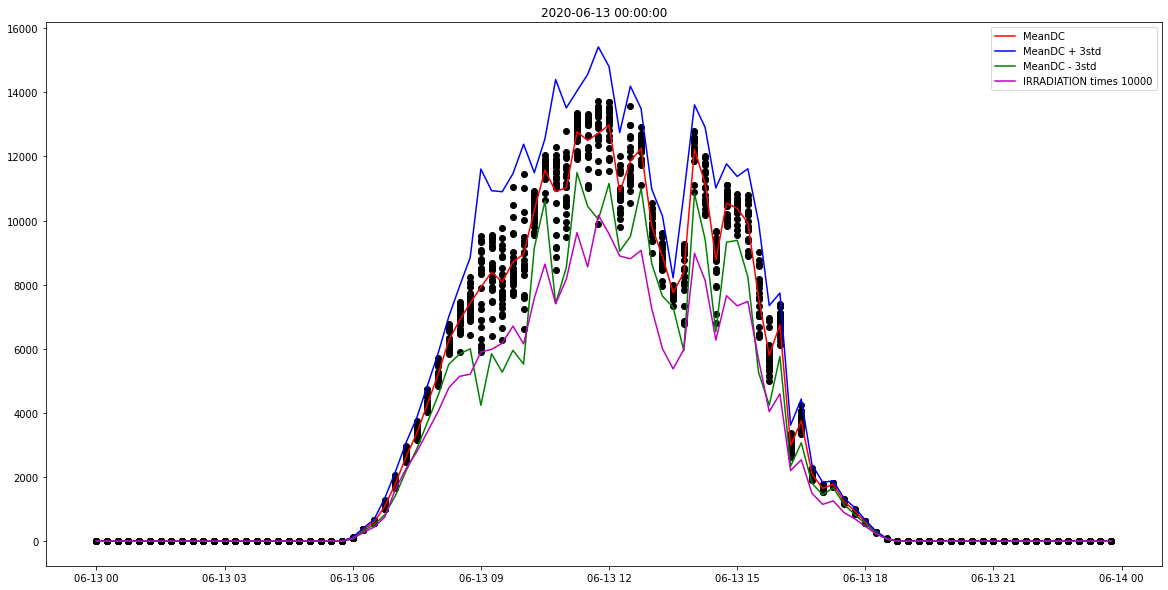

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.726863     0.993053
std          0.726863  1.000000     0.772329
IRRADIATION  0.993053  0.772329     1.000000
df['MeanDC'] std 3836.8187507121
df['std'] std 962.9408396861537


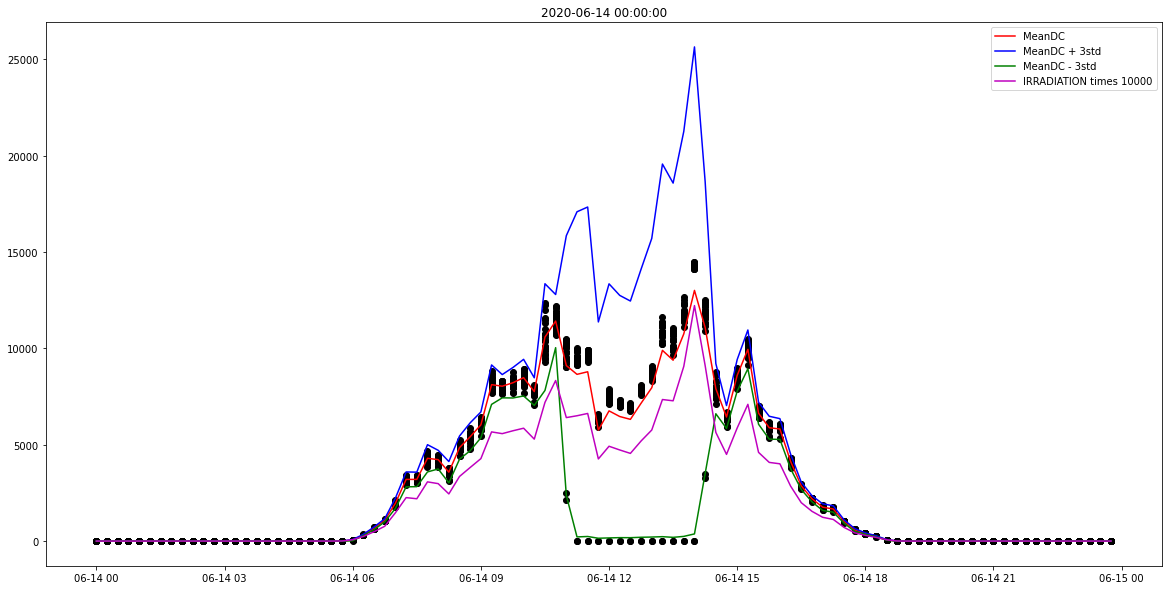

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.887305     0.997811
std          0.887305  1.000000     0.887433
IRRADIATION  0.997811  0.887433     1.000000
df['MeanDC'] std 3643.306679080749
df['std'] std 276.2550356995638


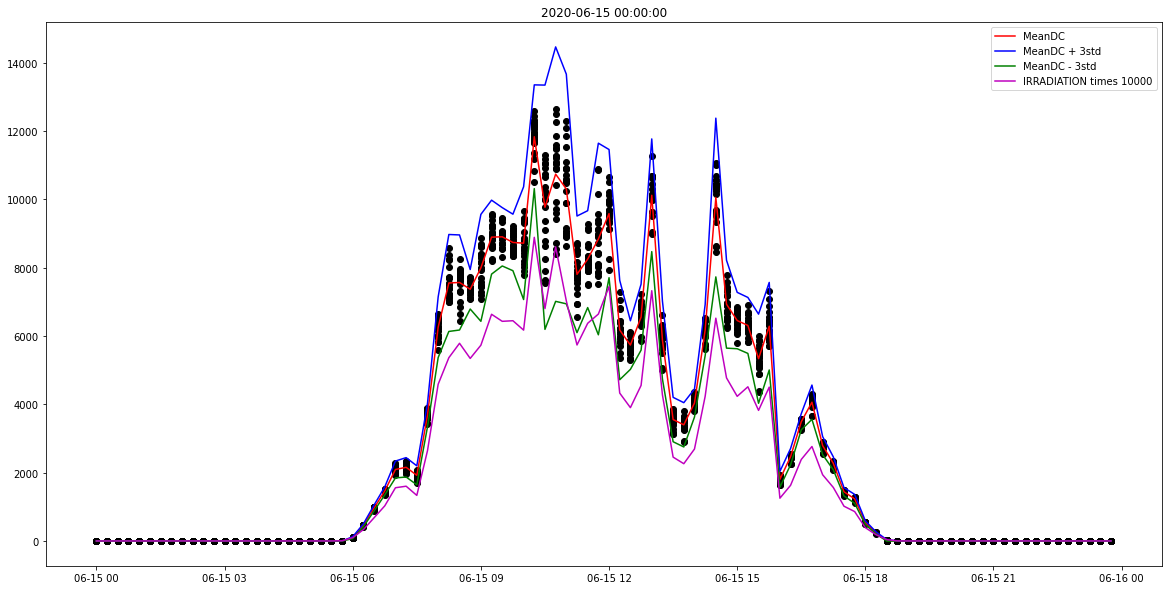

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.688985     0.998621
std          0.688985  1.000000     0.688211
IRRADIATION  0.998621  0.688211     1.000000
df['MeanDC'] std 3366.5137525768328
df['std'] std 264.44710205012115


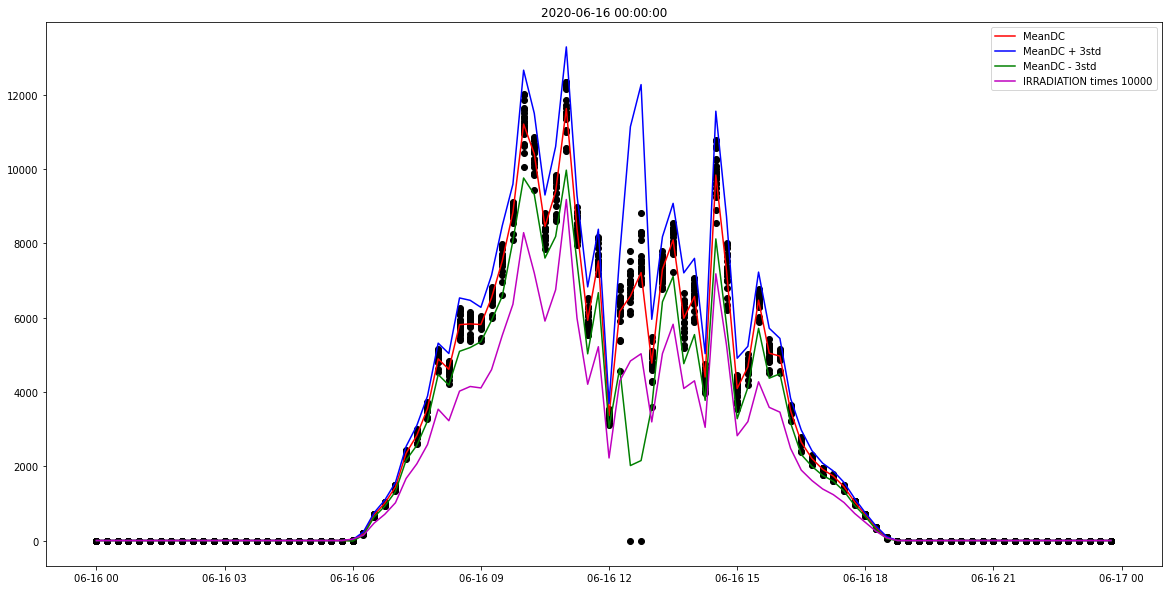

               MeanDC       std  IRRADIATION
MeanDC       1.000000  0.873265     0.997754
std          0.873265  1.000000     0.872309
IRRADIATION  0.997754  0.872309     1.000000
df['MeanDC'] std 3525.6438590854677
df['std'] std 182.0387201412094


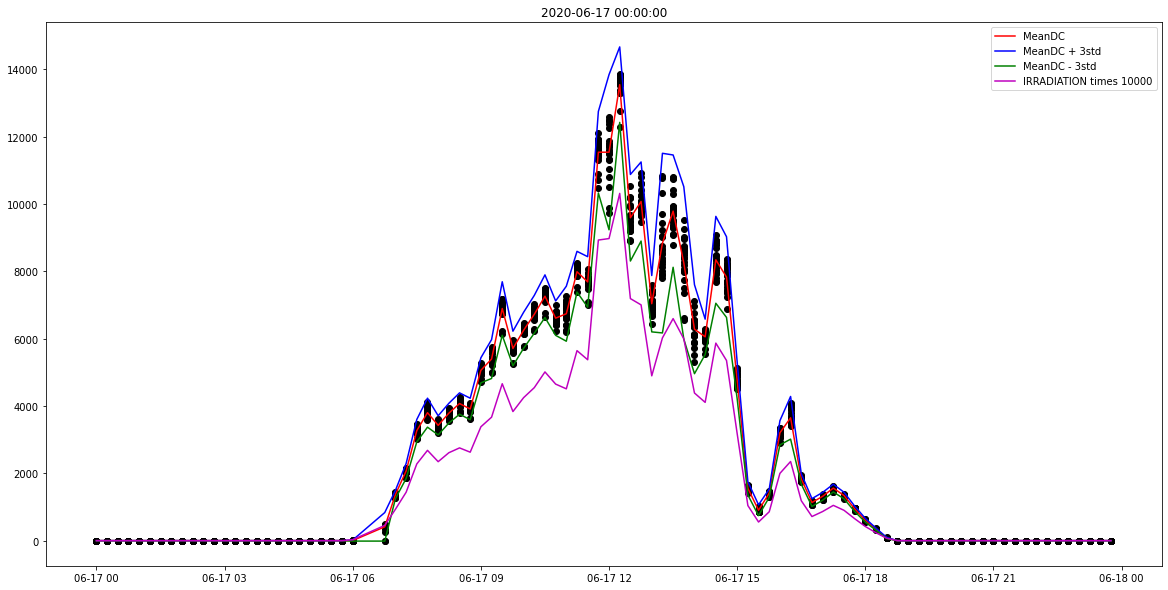

In [193]:
MeanDCstds = []
for dayofyear in merged_df.dt_y.dt.dayofyear.unique():
    d = datetime(2020, 1, 1) + timedelta(int(dayofyear) - 1)
    year = d.year
    month = d.month if d.month > 9 else '0' + str(d.month)
    day = d.day if d.day > 9 else '0' + str(d.day)
    temp = plot_dc_irr(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 23:59:00')
    MeanDCstds.append(temp)

In [194]:
MeanDCstds

[0.09588795898561427,
 0.04408312330171873,
 0.13636499841818986,
 0.10081462470445267,
 0.11579885840579891,
 0.04432930927356808,
 0.0776553714782707,
 0.06766263326030059,
 0.05107281893743815,
 0.08401954557740482,
 0.05369204481235112,
 0.10270396440730518,
 0.10513490876134746,
 0.06505270488312774,
 0.06959414301163314,
 0.04227137568925885,
 0.07685036178074951,
 0.06714502055874795,
 0.05185274530343304,
 0.04575504660172351,
 0.06884749440560896,
 0.07874976727678329,
 0.06938939094727398,
 0.13596244825727657,
 0.06294950929389806,
 0.0639511021440252,
 0.052957860394865185,
 0.03346684253651582,
 0.03135796121830729,
 0.06054933715862501,
 0.11749421875390018,
 0.060413830916537396,
 0.08218723416399935,
 0.08361261984518538]

In [168]:
def inv_rank(df, inv):
    temp = df[['SOURCE_KEY', 'DC_POWER']]
    temp.sort_values(by='DC_POWER', inplace=True)
    temp.reindex()
    keys = temp['SOURCE_KEY']
    dc_power = temp['DC_POWER']
    #print(keys)
    print(dc_power[0])
    r = 1
    max_t = dc_power[0]
    for i in range(len(keys)):
        if dc_power[i] > max_t:
            r+=1
        if inv == keys[i]:
            return r
        
def temp(row):
    row['pos'] = inv_rank(group, row['SOURCE_KEY'])
    return row
    
plant_gen['pos'] = 0
for _, group in plant_gen.groupby(plant_gen.index):
    m = pd.merge(plant_gen[plant_gen.index == _], group.apply(lambda row: temp(row), axis=1), how='left', on=['DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'dt'])
    print(m)
    #print(group.apply(lambda row: temp(row), axis=1))
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0   
7    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0   
8    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7098099.0   
9    4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6271355.0   
10   4135001  bvBOhCH3iADSZry       0.0       0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0   
7    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0   
8    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7098099.0   
9    4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6271355.0   
10   4135001  bvBOhCH3iADSZry       0.0       0.0          0.0    6316803.0   
11   4135001  iCRJl6

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0   
7    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0   
8    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7098099.0   
9    4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6271355.0   
10   4135001  bvBOhCH3iADSZry       0.0       0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7179966.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7098099.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0  

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7028673.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7179966.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6522172.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7098099.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6271355.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY   DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  37.142857  3.585714          0.0    6259559.0   
1    4135001  1IF53ai7Xc0U56Y  53.500000  5.162500          0.0    6183645.0   
2    4135001  3PZuoBAID5Wc2HD  58.000000  5.585714          0.0    6987759.0   
3    4135001  7JYdWkrLSPkdwr4  58.428571  5.628571          0.0    7602960.0   
4    4135001  McdE0feGgRqW7Ca  54.375000  5.250000          0.0    7158964.0   
5    4135001  VHMLBKoKgIrUVDU   0.000000  0.000000          0.0    7206408.0   
6    4135001  WRmjgnKYAwPKWDb  43.857143  4.228571          0.0    7028673.0   
7    4135001  ZnxXDlPa8U1GXgE  58.571429  5.671429          0.0    6522172.0   
8    4135001  ZoEaEvLYb1n2sOq  24.500000  2.366667          0.0    7098099.0   
9    4135001  adLQvlD726eNBSB  56.125000  5.425000          0.0    6271355.0   
10   4135001  bvBOhCH3iADSZry  37.000000  3.571429      

1166.857143
1166.857143
1166.857143
1166.857143
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1224.750000  119.275000    34.875000   
1    4135001  1IF53ai7Xc0U56Y  1334.285714  130.142857    39.142857   
2    4135001  3PZuoBAID5Wc2HD  1306.714286  127.414286    37.000000   
3    4135001  7JYdWkrLSPkdwr4  1338.125000  130.487500    39.000000   
4    4135001  McdE0feGgRqW7Ca  1331.857143  129.885714    38.714286   
5    4135001  VHMLBKoKgIrUVDU  1373.875000  134.075000    32.250000   
6    4135001  WRmjgnKYAwPKWDb  1298.857143  126.671429    36.857143   
7    4135001  YxYtjZvoooNbGkE  1292.125000  125.962500    37.250000   
8    4135001  ZnxXDlPa8U1GXgE  1380.571429  134.642857    40.000000   
9    4135001  ZoEaEvLYb1n2sOq  1290.000000  125.750000    37.000000   
10   4135001  adLQvlD726eNBSB  1348.142857  131.500000    39.000000   
11   4135001  bvBOhCH3iADSZry  1210.000000  117.812500    34.750000   
12   4135001  iCRJl6heRkivqQ3

1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
1740.125
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1842.285714  180.585714   162.428571   
1    4135001  1IF53ai7Xc0U56Y  2078.000000  203.712500   184.625000   
2    4135001  3PZuoBAID5Wc2HD  2071.250000  203.050000   181.875000   
3    4135001  7JYdWkrLSPkdwr4  2002.000000  196.275000   175.375000   
4    4135001  McdE0feGgRqW7Ca  2023.375000  198.362500   181.125000   
5    4135001  VHMLBKoKgIrUVDU  2069.125000  202.850000   172.375000   
6    4135001  WRmjgnKYAwPKWDb  2052.500000  201.200000   177.625000   
7    4135001  YxYtjZvoooNbGkE  1970.285714  193.128571   175.000000   
8    4135001  ZnxXDlPa8U1GXgE  2036.285714  199.628571   178.285714   
9    4135001  ZoEaEvLYb1n2sOq  1952.428571  191.414286   174.857143   
10   4135001  adLQvlD726eNBSB  2109.875000  206.

3702.75
3702.75
3702.75
3702.75
3702.75
3702.75
3702.75
3702.75
3702.75
3702.75
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  3917.500000  384.837500   359.875000   
1    4135001  1IF53ai7Xc0U56Y  4560.428571  447.500000   380.000000   
2    4135001  3PZuoBAID5Wc2HD  4523.714286  443.957143   376.000000   
3    4135001  7JYdWkrLSPkdwr4  4146.285714  407.100000   364.571429   
4    4135001  McdE0feGgRqW7Ca  5073.000000  497.414286   395.428571   
5    4135001  VHMLBKoKgIrUVDU  4215.285714  413.857143   365.857143   
6    4135001  WRmjgnKYAwPKWDb  4968.000000  487.242857   384.000000   
7    4135001  YxYtjZvoooNbGkE  4347.250000  426.700000   370.125000   
8    4135001  ZnxXDlPa8U1GXgE  4023.428571  395.185714   380.000000   
9    4135001  ZoEaEvLYb1n2sOq  4332.875000  425.362500   364.375000   
10   4135001  adLQvlD726eNBSB  4617.142857  453.100000   385.714286   
11   4135001  bvBOhCH3iADSZry  3702.750000  363.912500   347.625000 

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  3219.285714  315.885714   886.571429   
1    4135001  1IF53ai7Xc0U56Y  4325.500000  424.137500  1029.125000   
2    4135001  3PZuoBAID5Wc2HD  3819.375000  374.637500  1004.375000   
3    4135001  7JYdWkrLSPkdwr4  3608.625000  353.975000   980.750000   
4    4135001  McdE0feGgRqW7Ca  3564.571429  350.142857  1044.857143   
5    4135001  VHMLBKoKgIrUVDU  3707.250000  363.650000   990.000000   
6    4135001  WRmjgnKYAwPKWDb  3864.625000  378.975000   979.375000   
7    4135001  YxYtjZvoooNbGkE  3504.125000  343.950000  1008.125000   
8    4135001  ZnxXDlPa8U1GXgE  3475.285714  341.014286  1005.714286   
9    4135001  ZoEaEvLYb1n2sOq  3568.625000  350.312500   993.250000   
10   4135001  adLQvlD726eNBSB  3996.875000  391.937500  1034.500000   
11   4135001  bvBOhCH3iADSZry  3299.428571  323.700000   903.142

21  7117502.714 2020-05-15 10:30:00      0     17  
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
4342.428571
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  4360.571429  428.228571  1549.000000   
1    4135001  1IF53ai7Xc0U56Y  4895.125000  480.050000  1851.750000   
2    4135001  3PZuoBAID5Wc2HD  4999.750000  490.387500  1791.750000   
3    4135001  7JYdWkrLSPkdwr4  4605.428571  452.014286  1752.571429   
4    4135001  McdE0feGgRqW7Ca  5362.500000  525.612500  1929.250000   
5    4135001  VHMLBKoKgIrUVDU  4794.714286  470.442857  1760.142857   
6    4135001  WRmjgnKYAwPKWDb  4875.000000  478.337500  1729.125000   
7    4135001  YxYtjZvoooNbGkE  5081.142857  498.271429  1866.428571   
8    4135001  ZnxXDlPa8U1GXgE  4868.142857  4

5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
5704.375
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  9420.285714  920.042857  2155.000000   
1    4135001  1IF53ai7Xc0U56Y  7959.000000  778.487500  2544.375000   
2    4135001  3PZuoBAID5Wc2HD  8749.375000  855.275000  2471.250000   
3    4135001  7JYdWkrLSPkdwr4  7643.625000  747.912500  2410.625000   
4    4135001  McdE0feGgRqW7Ca  8642.875000  844.737500  2677.875000   
5    4135001  VHMLBKoKgIrUVDU  8312.000000  812.662500  2425.875000   
6    4135001  WRmjgnKYAwPKWDb  8566.000000  837.362500  2399.875000   
7    4135001  YxYtjZvoooNbGkE  6878.428571  673.628571  2552.857143   
8    4135001  ZnxXDlPa8U1GXgE  9124.625000  891.112500  2454.500000   
9    4135001  ZoEaEvLYb1n2sOq  7008.000000  686.214286  2511.857143   
10   4135001  adLQvlD726eNBSB  8465.375000  827.575000  2537.250000   
11   4135001  bvBOhCH3iADSZry  8394.4285

7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
7880.0
    PLANT_ID       SOURCE_KEY      DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7   8517.000000   832.962500  2860.000000   
1    4135001  1IF53ai7Xc0U56Y   9675.571429   945.671429  3186.142857   
2    4135001  3PZuoBAID5Wc2HD  10452.714290  1020.728571  3103.142857   
3    4135001  7JYdWkrLSPkdwr4   9645.571429   942.442857  3050.142857   
4    4135001  McdE0feGgRqW7Ca   9208.428571   899.857143  3322.857143   
5    4135001  VHMLBKoKgIrUVDU   9432.000000   921.614286  3114.571429   
6    4135001  WRmjgnKYAwPKWDb  10277.000000  1003.728571  3041.285714   
7    4135001  YxYtjZvoooNbGkE   8657.142857   846.557143  3175.714286   
8    4135001  ZnxXDlPa8U1GXgE   9099.571429   889.228571  3160.714286   
9    4135001  ZoEaEvLYb1n2sOq   8899.285714   870.071429  3130.571429   
10   4135001  adLQvlD726eNBSB  10091.714290   985.214286  3178.142857   
11   4135001  bvBOhCH3iADSZry   8894.250

    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6359.714286  623.042857  3384.857143   
1    4135001  1IF53ai7Xc0U56Y  7035.857143  689.014286  3749.571429   
2    4135001  3PZuoBAID5Wc2HD  7056.125000  691.012500  3679.625000   
3    4135001  7JYdWkrLSPkdwr4  6862.750000  672.125000  3599.000000   
4    4135001  McdE0feGgRqW7Ca  6752.000000  661.328571  3883.428571   
5    4135001  VHMLBKoKgIrUVDU  7005.625000  686.075000  3671.750000   
6    4135001  WRmjgnKYAwPKWDb  6822.375000  668.187500  3600.000000   
7    4135001  YxYtjZvoooNbGkE  6830.500000  668.987500  3751.500000   
8    4135001  ZnxXDlPa8U1GXgE  6917.500000  677.500000  3734.250000   
9    4135001  ZoEaEvLYb1n2sOq  6904.375000  676.187500  3701.250000   
10   4135001  adLQvlD726eNBSB  7089.571429  694.285714  3753.142857   
11   4135001  bvBOhCH3iADSZry  6266.571429  613.957143  3356.571429   
12   4135001  iCRJl6heRkivqQ3  6876.000000  673.425000  3859.750000   
13   4

10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
10578.875
    PLANT_ID       SOURCE_KEY     DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  10642.75000  1039.350000  4191.000000   
1    4135001  1IF53ai7Xc0U56Y  12194.71429  1189.642857  4628.714286   
2    4135001  3PZuoBAID5Wc2HD  12158.28571  1185.957143  4536.285714   
3    4135001  7JYdWkrLSPkdwr4  11674.75000  1139.525000  4456.375000   
4    4135001  McdE0feGgRqW7Ca  12040.57143  1174.300000  4755.857143   
5    4135001  VHMLBKoKgIrUVDU  11439.87500  1116.512500  4554.875000   
6    4135001  WRmjgnKYAwPKWDb  11913.71429  1162.257143  4447.571429   
7    4135001  YxYtjZvoooNbGkE  11996.87500  1170.612500  4609.875000   
8    4135001  ZnxXDlPa8U1GXgE  11394.62500  1111.950000  4610.875000   
9    4135001  ZoEaEvLYb1n2sOq  11917.25000  1162.850000  4552.875000  

5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
5285.285714
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6339.375000  620.987500  4840.250000   
1    4135001  1IF53ai7Xc0U56Y  7317.571429  716.442857  5370.571429   
2    4135001  3PZuoBAID5Wc2HD  8172.428571  799.800000  5274.857143   
3    4135001  7JYdWkrLSPkdwr4  6898.285714  675.514286  5149.857143   
4    4135001  McdE0feGgRqW7Ca  5285.285714  518.085714  5483.000000   
5    4135001  VHMLBKoKgIrUVDU  7161.857143  701.271429  5263.285714   
6    4135001  WRmjgnKYAwPKWDb  8292.428571  811.528571  5162.285714   
7    4135001  YxYtjZvoooNbGkE  6252.500000  612.437500  5310.500000   
8    4135001  ZnxXDlPa8U1GXgE  6732.250000  659.300000  5311.125000   
9    4135001  ZoEaEvLYb1n2

4333.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  4338.285714  426.014286  5477.714286   
1    4135001  1IF53ai7Xc0U56Y  4569.000000  448.437500  6064.625000   
2    4135001  3PZuoBAID5Wc2HD  4488.250000  440.637500  5988.375000   
3    4135001  7JYdWkrLSPkdwr4  4547.000000  446.312500  5823.750000   
4    4135001  McdE0feGgRqW7Ca  4975.857143  487.857143  6154.428571   
5    4135001  VHMLBKoKgIrUVDU  4656.000000  456.912500  5961.500000   
6    4135001  WRmjgnKYAwPKWDb  4358.875000  428.037500  5862.625000   
7    4135001  YxYtjZvoooNbGkE  4848.500000  475.500000  5979.000000   
8    4135001  ZnxXDlPa8U1GXgE  4843.142857  474.971429  5994.428571   
9    4135001  ZoEaEvLYb1n2sOq  4793.875000  470.262500  5953.875000   
10   4135001  adLQvlD726eNBSB  4580.500000  449.587500  6091.125000   
11   4135001  bvBOhCH3iADSZry  4333.000000  425.542857  5429.857143   
12   4135001  iCRJl6heRkivqQ3  4868.875000  477.525000  6107.125000   

481.5
481.5
481.5
481.5
481.5
481.5
481.5
481.5
    PLANT_ID       SOURCE_KEY    DC_POWER   AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  485.875000  47.012500  5739.750000   
1    4135001  1IF53ai7Xc0U56Y  528.375000  51.112500  6340.250000   
2    4135001  3PZuoBAID5Wc2HD  516.125000  49.925000  6258.000000   
3    4135001  7JYdWkrLSPkdwr4  511.625000  49.487500  6100.125000   
4    4135001  McdE0feGgRqW7Ca  524.750000  50.787500  6454.875000   
5    4135001  VHMLBKoKgIrUVDU  524.125000  50.725000  6241.875000   
6    4135001  WRmjgnKYAwPKWDb  510.500000  49.375000  6126.375000   
7    4135001  YxYtjZvoooNbGkE  518.375000  50.150000  6275.000000   
8    4135001  ZnxXDlPa8U1GXgE  536.142857  51.857143  6287.142857   
9    4135001  ZoEaEvLYb1n2sOq  514.875000  49.812500  6245.000000   
10   4135001  adLQvlD726eNBSB  536.500000  51.912500  6366.125000   
11   4135001  bvBOhCH3iADSZry  481.500000  46.550000  5692.750000   
12   4135001  iCRJl6heRkivqQ3  519.625000  50.275000  6

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       5754.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6357.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6274.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6116.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6471.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6258.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6142.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6291.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6304.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6261.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       6383.0    6277738.0   
11  

0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       5754.0    6265313.0   
1    4135001  McdE0feGgRqW7Ca       0.0       0.0       6471.0    7165435.0   
2    4135001  YxYtjZvoooNbGkE       0.0       0.0       6291.0    7186257.0   
3    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6261.0    7104360.0   
4    4135001  bvBOhCH3iADSZry       0.0       0.0       5707.0    6322510.0   
5    4135001  iCRJl6heRkivqQ3       0.0       0.0       6418.0    7184410.0   
6    4135001  pkci93gMrogZuBj       0.0       0.0       6375.0    7175477.0   
7    4135001  rGa61gmuvPhdLxV       0.0       0.0       6373.0    7117866.0   
8    4135001  sjndEbLyjtCKgGv       0.0       0.0       6350.0    7023182.0   
9    4135001  uHbuxQJl8lW7ozc       0.0       0.0       6387.0    7045068.0   
10   4135001  wCURE6d3bPkepu2       0.0       0.0       6329.0    6788927.0   
11   4135001  z9Y9gH1T5YWrNu

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       5754.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6471.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6291.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6261.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6277738.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       5754.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6471.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6291.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6261.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6277738.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       5754.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6471.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6291.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6261.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6277738.0   


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6277738.0   


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6277738.0   


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6265313.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6190002.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6994033.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7609076.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7165435.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7212666.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7034815.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7186257.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6528476.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7104360.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          

1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
1049.375
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1054.375000  102.475000    36.125000   
1    4135001  1IF53ai7Xc0U56Y  1174.714286  114.257143    39.857143   
2    4135001  3PZuoBAID5Wc2HD  1167.285714  113.528571    39.285714   
3    4135001  7JYdWkrLSPkdwr4  1119.714286  108.814286    36.857143   
4    4135001  McdE0feGgRqW7Ca  1152.125000  112.012500    39.625000   
5    4135001  VHMLBKoKgIrUVDU  1146.428571  111.485714    38.285714   
6    4135001  WRmjgnKYAwPKWDb  1158.142857  112.614286    38.714286   
7    4135001  YxYtjZvoooNbGkE  1108.285714  107.742857    37.714286   
8    4135001  ZnxXDlPa8U1GXgE  1150.285714  111.842857    38.714286   
9    4135001  ZoEaEvLYb1n2sOq  1100.285714  106.942857    36.571429   
10   4135001  adLQvlD726eNBSB  1190.285714  115.771429    40.285714   
11  

3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
3922.714286
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  3960.000000  389.114286   315.285714   
1    4135001  1IF53ai7Xc0U56Y  4387.000000  430.785714   342.857143   
2    4135001  3PZuoBAID5Wc2HD  4354.285714  427.614286   340.428571   
3    4135001  7JYdWkrLSPkdwr4  4226.375000  415.125000   333.750000   
4    4135001  McdE0feGgRqW7Ca  4253.750000  417.812500   337.125000   
5    4135001  VHMLBKoKgIrUVDU  4353.125000  427.487500   341.000000   
6    4135001  WRmjgnKYAwPKWDb  4297.142857  422.100000   337.000000   
7    4135001  YxYtjZvoooNbGkE  4161.250000  408.787500   329.500000   
8    4135001  ZnxXDlPa8U1GXgE  4228.571429  415.385714   335.000000   
9    4135001  ZoEaEvLYb1n2

6095.75
6095.75
6095.75
6095.75
6095.75
6095.75
6095.75
6095.75
6095.75
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6135.750000  601.187500   689.250000   
1    4135001  1IF53ai7Xc0U56Y  6910.750000  676.812500   758.875000   
2    4135001  3PZuoBAID5Wc2HD  6697.750000  656.012500   751.500000   
3    4135001  7JYdWkrLSPkdwr4  6347.857143  621.871429   728.571429   
4    4135001  McdE0feGgRqW7Ca  6607.000000  647.200000   735.714286   
5    4135001  VHMLBKoKgIrUVDU  6643.714286  650.742857   751.571429   
6    4135001  WRmjgnKYAwPKWDb  6545.875000  641.187500   738.375000   
7    4135001  YxYtjZvoooNbGkE  6316.571429  618.842857   725.142857   
8    4135001  ZnxXDlPa8U1GXgE  6525.375000  639.237500   731.875000   
9    4135001  ZoEaEvLYb1n2sOq  6234.857143  610.828571   716.714286   
10   4135001  adLQvlD726eNBSB  6839.125000  669.812500   764.000000   
11   4135001  bvBOhCH3iADSZry  6095.750000  597.275000   681.875000   
12   

5475.75
5475.75
5475.75
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  5574.875000  546.387500  1099.000000   
1    4135001  1IF53ai7Xc0U56Y  6108.142857  598.471429  1227.142857   
2    4135001  3PZuoBAID5Wc2HD  6094.428571  597.114286  1217.571429   
3    4135001  7JYdWkrLSPkdwr4  5945.875000  582.587500  1177.500000   
4    4135001  McdE0feGgRqW7Ca  6050.125000  592.812500  1196.250000   
5    4135001  VHMLBKoKgIrUVDU  6115.625000  599.212500  1212.000000   
6    4135001  WRmjgnKYAwPKWDb  5966.285714  584.628571  1201.714286   
7    4135001  YxYtjZvoooNbGkE  5919.750000  580.075000  1170.500000   
8    4135001  ZnxXDlPa8U1GXgE  5927.428571  580.800000  1181.285714   
9    4135001  ZoEaEvLYb1n2sOq  5832.500000  571.550000  1166.875000   
10   4135001  adLQvlD726eNBSB  6174.428571  604.942857  1242.000000   
11   4135001  bvBOhCH3iADSZry  5475.750000  536.687500  1085.375000   
12   4135001  iCRJl6heRkivqQ3  5941.625000  582.22500

6608.714286
6608.714286
6608.714286
6608.714286
6608.714286
6608.714286
6608.714286
6608.714286
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7432.000000  727.614286  1618.857143   
1    4135001  1IF53ai7Xc0U56Y  7505.875000  734.750000  1763.375000   
2    4135001  3PZuoBAID5Wc2HD  7764.625000  759.950000  1766.875000   
3    4135001  7JYdWkrLSPkdwr4  6839.857143  669.871429  1700.857143   
4    4135001  McdE0feGgRqW7Ca  6964.857143  682.014286  1709.714286   
5    4135001  VHMLBKoKgIrUVDU  7224.142857  707.371429  1761.857143   
6    4135001  WRmjgnKYAwPKWDb  7914.000000  774.537500  1747.125000   
7    4135001  YxYtjZvoooNbGkE  6943.714286  679.928571  1683.285714   
8    4135001  ZnxXDlPa8U1GXgE  7600.750000  744.000000  1734.500000   
9    4135001  ZoEaEvLYb1n2sOq  6633.571429  649.714286  1665.714286   
10   4135001  adLQvlD726eNBSB  7628.625000  746.687500  1787.125000   
11   4135001  bvBOhCH3iADSZry  7059.285714  691.2142

7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
7275.375
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  8442.250000  826.137500  2264.500000   
1    4135001  1IF53ai7Xc0U56Y  8614.875000  842.825000  2407.750000   
2    4135001  3PZuoBAID5Wc2HD  8632.428571  844.542857  2448.428571   
3    4135001  7JYdWkrLSPkdwr4  8381.285714  820.114286  2335.000000   
4    4135001  McdE0feGgRqW7Ca  7751.571429  758.757143  2308.428571   
5    4135001  VHMLBKoKgIrUVDU  8696.142857  850.771429  2430.857143   
6    4135001  WRmjgnKYAwPKWDb  9206.714286  900.471429  2453.000000   
7    4135001  YxYtjZvoooNbGkE  7761.857143  759.785714  2285.857143   
8    4135001  ZnxXDlPa8U1GXgE  8081.571429  790.914286  2385.714286   
9    4135001  ZoEaEvLYb1n2sOq  8083.714286  791.057143  2273.571429   
10   4135001  adLQvlD

7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
7913.285714
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  9031.857143  883.528571  2832.142857   
1    4135001  1IF53ai7Xc0U56Y  8480.428571  829.771429  2980.571429   
2    4135001  3PZuoBAID5Wc2HD  9016.000000  881.900000  3019.428571   
3    4135001  7JYdWkrLSPkdwr4  8857.750000  866.537500  2900.625000   
4    4135001  McdE0feGgRqW7Ca  9172.875000  897.212500  2883.250000   
5    4135001  VHMLBKoKgIrUVDU  9642.625000  943.000000  3020.125000   
6    4135001  WRmjgnKYAwPKWDb  9310.142857  910.628571  3031.000000   
7    4135001  YxYtjZvoooNbGkE  9089.000000  889.062500  2853.875000   
8    4135001  ZnxXDlPa8U1GXgE  9469.714286  926.128571  2950.428571   
9    4135001  ZoEaEvLYb1n2sOq  8769.750000  857.962500  2831.125000   
10 

8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
8771.857143
    PLANT_ID       SOURCE_KEY      DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  10307.000000  1007.650000  3450.125000   
1    4135001  1IF53ai7Xc0U56Y  10558.000000  1031.662500  3654.125000   
2    4135001  3PZuoBAID5Wc2HD  10864.000000  1061.437500  3705.750000   
3    4135001  7JYdWkrLSPkdwr4  10846.428570  1059.900000  3552.571429   
4    4135001  McdE0feGgRqW7Ca  10750.428570  1050.371429  3529.142857   
5    4135001  VHMLBKoKgIrUVDU  11192.857140  1093.400000  3689.571429   
6    4135001  WRmjgnKYAwPKWDb  10963.625000  1071.312500  3698.500000   
7    4135001  YxYtjZvoooNbGkE  10585.571430  1034.685714  3490.857143   
8    4135001  ZnxXDlPa8U1GXgE  11004.250000  1075.412500  3603.125000   
9    4135001  ZoEaEvLYb1n2sOq  10442.857140  1020.657143  3474.142

6400.625
6400.625
6400.625
6400.625
6400.625
6400.625
6400.625
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6833.625000  669.162500  4612.500000   
1    4135001  1IF53ai7Xc0U56Y  6786.571429  664.642857  4802.142857   
2    4135001  3PZuoBAID5Wc2HD  6800.000000  665.942857  4879.571429   
3    4135001  7JYdWkrLSPkdwr4  6400.625000  627.012500  4716.500000   
4    4135001  McdE0feGgRqW7Ca  7624.625000  746.325000  4768.750000   
5    4135001  VHMLBKoKgIrUVDU  6854.250000  671.212500  4919.000000   
6    4135001  WRmjgnKYAwPKWDb  6439.000000  630.757143  4867.000000   
7    4135001  YxYtjZvoooNbGkE  6945.125000  680.075000  4701.625000   
8    4135001  ZnxXDlPa8U1GXgE  7738.571429  757.457143  4860.000000   
9    4135001  ZoEaEvLYb1n2sOq  6888.125000  674.525000  4626.500000   
10   4135001  adLQvlD726eNBSB  6833.285714  669.228571  4902.428571   
11   4135001  bvBOhCH3iADSZry  6453.375000  632.075000  4487.750000   
12   4135001  

21  7127302.286 2020-05-16 14:30:00      0     11  
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
6805.625
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6980.125000  683.600000  5305.625000   
1    4135001  1IF53ai7Xc0U56Y  7098.714286  695.142857  5532.714286   
2    4135001  3PZuoBAID5Wc2HD  7120.571429  697.257143  5603.285714   
3    4135001  7JYdWkrLSPkdwr4  7122.857143  697.500000  5422.142857   
4    4135001  McdE0feGgRqW7Ca  7761.000000  759.771429  5506.571429   
5    4135001  VHMLBKoKgIrUVDU  7496.428571  733.957143  5645.857143   
6    4135001  WRmjgnKYAwPKWDb  7123.428571  697.542857  5576.000000   
7    4135001  YxYtjZvoooNbGkE  7402.142857  724.757143  5423.285714   
8    4135001  ZnxXDlPa8U1GXgE  7468.000000  731.171429  5611.571429   
9    4135001  ZoEaEvLYb1n2sOq  7157.8571

3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
3590.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  3639.625000  357.725000  5858.750000   
1    4135001  1IF53ai7Xc0U56Y  3930.625000  386.225000  6114.375000   
2    4135001  3PZuoBAID5Wc2HD  3906.875000  383.900000  6182.625000   
3    4135001  7JYdWkrLSPkdwr4  3791.142857  372.614286  5997.714286   
4    4135001  McdE0feGgRqW7Ca  3975.000000  390.557143  6112.000000   
5    4135001  VHMLBKoKgIrUVDU  3899.857143  383.228571  6239.000000   
6    4135001  WRmjgnKYAwPKWDb  3861.750000  379.512500  6147.250000   
7    4135001  YxYtjZvoooNbGkE  3848.142857  378.157143  6010.000000   
8    4135001  ZnxXDlPa8U1GXgE  3898.285714  383.042857  6204.714286   
9    4135001  ZoEaEvLYb1n2sOq  3813.285714  374.714286  5921.000000   
10   4135001  adLQvlD726eNBSB  3963.125000  389.400000  6222.750000   
11   4135001  bvBOhCH3

2397.857143
2397.857143
2397.857143
2397.857143
2397.857143
2397.857143
2397.857143
2397.857143
2397.857143
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  2414.571429  236.757143  6075.000000   
1    4135001  1IF53ai7Xc0U56Y  2661.571429  261.042857  6353.142857   
2    4135001  3PZuoBAID5Wc2HD  2637.571429  258.657143  6419.857143   
3    4135001  7JYdWkrLSPkdwr4  2563.500000  251.387500  6230.250000   
4    4135001  McdE0feGgRqW7Ca  2645.375000  259.450000  6347.875000   
5    4135001  VHMLBKoKgIrUVDU  2625.875000  257.537500  6477.750000   
6    4135001  WRmjgnKYAwPKWDb  2602.142857  255.171429  6381.428571   
7    4135001  YxYtjZvoooNbGkE  2588.500000  253.850000  6241.875000   
8    4135001  ZnxXDlPa8U1GXgE  2645.285714  259.428571  6437.285714   
9    4135001  ZoEaEvLYb1n2sOq  2578.750000  252.862500  6152.375000   
10   4135001  adLQvlD726eNBSB  2681.142857  262.971429  6463.571429   
11   4135001  bvBOhCH3iADSZry  2397.8571

    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1515.714286  148.028571  6217.000000   
1    4135001  1IF53ai7Xc0U56Y  1630.750000  159.587500  6512.000000   
2    4135001  3PZuoBAID5Wc2HD  1616.250000  158.087500  6576.125000   
3    4135001  7JYdWkrLSPkdwr4  1580.571429  154.542857  6382.857143   
4    4135001  McdE0feGgRqW7Ca  1627.428571  159.228571  6506.428571   
5    4135001  VHMLBKoKgIrUVDU  1618.571429  158.400000  6634.000000   
6    4135001  WRmjgnKYAwPKWDb  1599.250000  156.375000  6536.250000   
7    4135001  YxYtjZvoooNbGkE  1592.571429  155.771429  6397.142857   
8    4135001  ZnxXDlPa8U1GXgE  1634.000000  159.937500  6594.250000   
9    4135001  ZoEaEvLYb1n2sOq  1583.571429  154.885714  6307.000000   
10   4135001  adLQvlD726eNBSB  1646.250000  161.150000  6624.375000   
11   4135001  bvBOhCH3iADSZry  1504.571429  146.914286  6063.000000   
12   4135001  iCRJl6heRkivqQ3  1613.285714  157.857143  6358.714286   
13   4

21  7128513.571 2020-05-16 17:45:00      0     11  
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
373.0
    PLANT_ID       SOURCE_KEY    DC_POWER   AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  373.625000  36.100000  6285.500000   
1    4135001  1IF53ai7Xc0U56Y  398.428571  38.500000  6584.714286   
2    4135001  3PZuoBAID5Wc2HD  391.000000  37.785714  6649.142857   
3    4135001  7JYdWkrLSPkdwr4  402.428571  38.914286  6452.428571   
4    4135001  McdE0feGgRqW7Ca  393.750000  38.050000  6578.500000   
5    4135001  VHMLBKoKgIrUVDU  413.714286  39.985714  6705.285714   
6    4135001  WRmjgnKYAwPKWDb  385.714286  37.271429  6608.428571   
7    4135001  YxYtjZvoooNbGkE  384.625000  37.187500  6467.875000   
8    4135001  ZnxXDlPa8U1GXgE  400.428571  38.728571  6668.000000   
9    4135001  ZoEaEvLYb1n2sOq  382.750000  36.987500  6377.125000   
10   4135001  adLQvlD726eNBSB  405.285714  39.157143  669

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       6292.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6592.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6656.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6461.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6586.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6714.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6615.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6475.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6676.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6384.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       6292.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6592.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6656.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6461.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6586.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6714.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6615.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6475.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6676.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6384.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       6705.0    6284443.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       6292.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6592.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6656.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6461.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6586.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6714.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6615.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6475.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6676.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6384.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       6705.0    6284443.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       6292.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6592.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6656.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6461.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6586.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6714.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6615.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6475.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6676.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6384.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0  

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       6292.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6592.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6656.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6461.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6586.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6714.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6615.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6475.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6676.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6384.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0    

0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       6292.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       6592.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       6656.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       6461.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       6586.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       6714.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       6615.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       6475.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       6676.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       6384.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       6705.0    6284443.0   
11   4135001  bvBOhCH3iADSZry   

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6284443.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0      

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6284443.0   
11   4135001

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6271605.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6196594.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7000689.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7615537.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7172021.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7219380.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7041430.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7192732.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6535152.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7110744.0   
10   4135001  adLQvlD726eNBSB       0.0       0

1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
1285.714286
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1285.714286  125.071429    46.285714   
1    4135001  1IF53ai7Xc0U56Y  1502.125000  146.750000    54.625000   
2    4135001  3PZuoBAID5Wc2HD  1490.625000  145.625000    53.625000   
3    4135001  7JYdWkrLSPkdwr4  1427.625000  139.337500    50.000000   
4    4135001  McdE0feGgRqW7Ca  1413.714286  138.000000    50.857143   
5    4135001  VHMLBKoKgIrUVDU  1446.750000  141.225000    51.250000   
6    4135001  WRmjgnKYAwPKWDb  1479.500000  144.475000    53.000000   
7    4135001  YxYtjZvoooNbGkE  1377.500000  134.437500    48.750000   
8    4135001  ZnxXDlPa8U1GXgE  1420.625000  138.625000    51.000000   
9    4135001  ZoEaEvLYb1n2sOq  1396.375000  136.137500    49.000000   
10   4135001  adLQvlD726eNBSB  1522.000000  148.712

4797.0
4797.0
4797.0
4797.0
4797.0
4797.0
4797.0
4797.0
4797.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  4942.285714  484.557143   349.428571   
1    4135001  1IF53ai7Xc0U56Y  5436.428571  532.828571   393.285714   
2    4135001  3PZuoBAID5Wc2HD  5484.142857  537.528571   389.000000   
3    4135001  7JYdWkrLSPkdwr4  5174.125000  507.225000   372.000000   
4    4135001  McdE0feGgRqW7Ca  5053.625000  495.500000   365.625000   
5    4135001  VHMLBKoKgIrUVDU  5390.125000  528.337500   385.750000   
6    4135001  WRmjgnKYAwPKWDb  5437.571429  532.957143   385.714286   
7    4135001  YxYtjZvoooNbGkE  4994.625000  489.750000   361.625000   
8    4135001  ZnxXDlPa8U1GXgE  5168.000000  506.612500   372.625000   
9    4135001  ZoEaEvLYb1n2sOq  4919.750000  482.512500   354.750000   
10   4135001  adLQvlD726eNBSB  5547.142857  543.685714   400.857143   
11   4135001  bvBOhCH3iADSZry  4832.000000  473.971429   346.142857   
12   4135001  

    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7185.500000  703.612500   738.875000   
1    4135001  1IF53ai7Xc0U56Y  7885.875000  771.925000   826.750000   
2    4135001  3PZuoBAID5Wc2HD  7749.125000  758.562500   824.625000   
3    4135001  7JYdWkrLSPkdwr4  7480.285714  732.357143   790.000000   
4    4135001  McdE0feGgRqW7Ca  7567.000000  740.814286   778.285714   
5    4135001  VHMLBKoKgIrUVDU  7781.714286  761.742857   812.857143   
6    4135001  WRmjgnKYAwPKWDb  7624.875000  746.475000   809.000000   
7    4135001  YxYtjZvoooNbGkE  7437.714286  728.214286   769.000000   
8    4135001  ZnxXDlPa8U1GXgE  7738.285714  757.542857   795.714286   
9    4135001  ZoEaEvLYb1n2sOq  7346.142857  719.285714   761.428571   
10   4135001  adLQvlD726eNBSB  7927.375000  775.962500   838.625000   
11   4135001  bvBOhCH3iADSZry  7040.125000  689.425000   730.000000   
12   4135001  iCRJl6heRkivqQ3  7385.571429  723.142857   756.857143   
13   4

7695.0
7695.0
7695.0
7695.0
7695.0
7695.0
7695.0
7695.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7851.285714  768.500000  1252.714286   
1    4135001  1IF53ai7Xc0U56Y  8662.142857  847.514286  1401.428571   
2    4135001  3PZuoBAID5Wc2HD  8514.857143  833.157143  1395.428571   
3    4135001  7JYdWkrLSPkdwr4  8351.125000  817.212500  1328.625000   
4    4135001  McdE0feGgRqW7Ca  8501.750000  831.875000  1341.500000   
5    4135001  VHMLBKoKgIrUVDU  8633.250000  844.700000  1373.375000   
6    4135001  WRmjgnKYAwPKWDb  8320.285714  814.200000  1356.285714   
7    4135001  YxYtjZvoooNbGkE  8338.625000  815.975000  1307.000000   
8    4135001  ZnxXDlPa8U1GXgE  8341.000000  816.200000  1330.571429   
9    4135001  ZoEaEvLYb1n2sOq  8234.625000  805.850000  1295.625000   
10   4135001  adLQvlD726eNBSB  8673.142857  848.571429  1417.000000   
11   4135001  bvBOhCH3iADSZry  7695.000000  753.214286  1228.714286   
12   4135001  iCRJl6h

    PLANT_ID       SOURCE_KEY     DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  10591.75000  1034.712500  2128.250000   
1    4135001  1IF53ai7Xc0U56Y  11839.14286  1154.714286  2400.142857   
2    4135001  3PZuoBAID5Wc2HD  11445.71429  1117.142857  2397.571429   
3    4135001  7JYdWkrLSPkdwr4  10010.85714   978.214286  2267.000000   
4    4135001  McdE0feGgRqW7Ca   9503.62500   928.437500  2315.750000   
5    4135001  VHMLBKoKgIrUVDU  10875.71429  1062.300000  2337.285714   
6    4135001  WRmjgnKYAwPKWDb  10737.57143  1048.571429  2337.714286   
7    4135001  YxYtjZvoooNbGkE   9655.75000   943.475000  2266.625000   
8    4135001  ZnxXDlPa8U1GXgE  10803.85714  1055.200000  2294.000000   
9    4135001  ZoEaEvLYb1n2sOq   9901.00000   967.250000  2246.000000   
10   4135001  adLQvlD726eNBSB  11778.71429  1149.600000  2429.571429   
11   4135001  bvBOhCH3iADSZry   9644.00000   943.012500  2092.500000   
12   4135001  iCRJl6heRkivqQ3   8594.25000   839.975000  2261.87

10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
10160.14286
    PLANT_ID       SOURCE_KEY     DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  10160.14286   991.828571  2945.142857   
1    4135001  1IF53ai7Xc0U56Y  12995.50000  1267.075000  3265.500000   
2    4135001  3PZuoBAID5Wc2HD  12974.00000  1264.950000  3272.250000   
3    4135001  7JYdWkrLSPkdwr4  12680.87500  1236.375000  3100.750000   
4    4135001  McdE0feGgRqW7Ca  13192.42857  1286.271429  3153.714286   
5    4135001  VHMLBKoKgIrUVDU  12804.00000  1248.387500  3212.000000   
6    4135001  WRmjgnKYAwPKWDb  12425.75000  1211.862500  3191.250000   
7    4135001  YxYtjZvoooNbGkE  12706.28571  1238.842857  3050.428571   
8    4135001  ZnxXDlPa8U1GXgE  12741.87500  1242.300000  3169.875000   
9    4135001  ZoEaEvLYb1n2sOq  12804.50000  1248.437500  3040.000000   
10   4135001  adLQvlD726eNBS

9087.142857
    PLANT_ID       SOURCE_KEY      DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  10496.142860  1025.042857  3836.857143   
1    4135001  1IF53ai7Xc0U56Y  10234.714290   999.557143  4340.428571   
2    4135001  3PZuoBAID5Wc2HD  10330.857140  1008.814286  4345.000000   
3    4135001  7JYdWkrLSPkdwr4   9572.125000   935.412500  4161.625000   
4    4135001  McdE0feGgRqW7Ca  11685.750000  1140.675000  4208.000000   
5    4135001  VHMLBKoKgIrUVDU   9813.375000   958.837500  4259.375000   
6    4135001  WRmjgnKYAwPKWDb   9087.142857   887.614286  4232.285714   
7    4135001  YxYtjZvoooNbGkE  10594.428570  1034.957143  4134.000000   
8    4135001  ZnxXDlPa8U1GXgE  10550.750000  1030.475000  4172.375000   
9    4135001  ZoEaEvLYb1n2sOq   9507.857143   929.071429  4106.714286   
10   4135001  adLQvlD726eNBSB  10579.571430  1032.742857  4397.714286   
11   4135001  bvBOhCH3iADSZry   9936.571429   970.800000  3786.000000   
12   4135001  iCRJl6heRkivqQ3  10641.71

4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
4763.428571
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7081.500000  692.212500  4515.000000   
1    4135001  1IF53ai7Xc0U56Y  6147.875000  602.000000  5030.875000   
2    4135001  3PZuoBAID5Wc2HD  6893.250000  674.812500  5055.125000   
3    4135001  7JYdWkrLSPkdwr4  5701.857143  558.442857  4848.857143   
4    4135001  McdE0feGgRqW7Ca  5811.428571  569.614286  4910.142857   
5    4135001  VHMLBKoKgIrUVDU  6636.857143  649.242857  4956.571429   
6    4135001  WRmjgnKYAwPKWDb  6539.375000  640.475000  4940.375000   
7    4135001  YxYtjZvoooNbGkE  5238.285714  513.685714  4803.714286   
8    4135001  ZnxXDlPa8U1GXgE  6222.571429  609.228571  4871.142857   
9    4135001  ZoEaEvLYb1n2sOq  5249.000000  514.671429  4773.857143   
10   4135001  adLQvlD726eNBSB  6491.000000  635.762500  5105.125000   
11   4135001  bv

7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
7522.125
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  8383.000000  819.428571  5088.428571   
1    4135001  1IF53ai7Xc0U56Y  8205.714286  802.271429  5602.857143   
2    4135001  3PZuoBAID5Wc2HD  8981.428571  877.671429  5639.428571   
3    4135001  7JYdWkrLSPkdwr4  9202.125000  898.962500  5409.125000   
4    4135001  McdE0feGgRqW7Ca  8096.250000  791.550000  5476.750000   
5    4135001  VHMLBKoKgIrUVDU  9894.875000  965.762500  5545.875000   
6    4135001  WRmjgnKYAwPKWDb  9138.285714  892.600000  5532.857143   
7    4135001  YxYtjZvoooNbGkE  7950.625000  777.737500  5344.375000   
8    4135001  ZnxXDlPa8U1GXgE  8731.285714  853.300000  5441.142857   
9    4135001  ZoEaEvLYb1n2sOq  8618.625000  842.262500  5316.750000   
10   4135001  adLQvlD726eNBSB  8624.714286  842.914286  5682.285714   
11   4135001  bvBOhCH3iADSZry  8402.8571

2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
2991.571429
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  3039.857143  298.357143  5545.857143   
1    4135001  1IF53ai7Xc0U56Y  4372.625000  428.912500  6123.250000   
2    4135001  3PZuoBAID5Wc2HD  5312.750000  520.600000  6159.125000   
3    4135001  7JYdWkrLSPkdwr4  3451.142857  338.857143  5937.000000   
4    4135001  McdE0feGgRqW7Ca  3302.428571  324.242857  6005.571429   
5    4135001  VHMLBKoKgIrUVDU  4206.000000  412.528571  6079.142857   
6    4135001  WRmjgnKYAwPKWDb  5169.375000  506.512500  6058.750000   
7    4135001  YxYtjZvoooNbGkE  3836.000000  376.385714  5884.714286   
8    4135001  ZnxXDlPa8U1GXgE  3627.250000  356.050000  5957.125000   
9    4135001  ZoEaEvLYb1n2sOq  4942.714286  484.300000  5859.285714   
10   4135001  adLQvlD726eNB

5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
5536.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  5536.000000  542.314286  6562.428571   
1    4135001  1IF53ai7Xc0U56Y  6771.714286  663.085714  7193.571429   
2    4135001  3PZuoBAID5Wc2HD  6403.375000  627.175000  7245.625000   
3    4135001  7JYdWkrLSPkdwr4  6368.625000  623.812500  6989.250000   
4    4135001  McdE0feGgRqW7Ca  6147.375000  602.150000  7073.875000   
5    4135001  VHMLBKoKgIrUVDU  6525.375000  639.112500  7170.375000   
6    4135001  WRmjgnKYAwPKWDb  6252.000000  612.425000  7138.250000   
7    4135001  YxYtjZvoooNbGkE  6448.285714  631.485714  6965.571429   
8    4135001  ZnxXDlPa8U1GXgE  6212.375000  608.375000  7056.375000   
9    4135001  ZoEaEvLYb1n2sOq  6675.285714  653.728571  6923.857143   
10   4135001  adLQvlD726eNBSB  6729.285714  658.914286  7296.8571

1527.0
1527.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1564.875000  153.125000  6965.250000   
1    4135001  1IF53ai7Xc0U56Y  1696.250000  166.187500  7671.375000   
2    4135001  3PZuoBAID5Wc2HD  1572.000000  153.962500  7707.500000   
3    4135001  7JYdWkrLSPkdwr4  1656.428571  162.342857  7441.428571   
4    4135001  McdE0feGgRqW7Ca  1723.571429  168.928571  7517.857143   
5    4135001  VHMLBKoKgIrUVDU  1698.285714  166.442857  7629.428571   
6    4135001  WRmjgnKYAwPKWDb  1527.000000  149.562500  7588.250000   
7    4135001  YxYtjZvoooNbGkE  1690.857143  165.714286  7408.714286   
8    4135001  ZnxXDlPa8U1GXgE  1706.857143  167.285714  7499.428571   
9    4135001  ZoEaEvLYb1n2sOq  1675.142857  164.042857  7377.285714   
10   4135001  adLQvlD726eNBSB  1713.375000  167.937500  7777.875000   
11   4135001  bvBOhCH3iADSZry  1554.375000  152.100000  6848.875000   
12   4135001  iCRJl6heRkivqQ3  1699.000000  166.542857  7432.57

277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
277.8571429
    PLANT_ID       SOURCE_KEY    DC_POWER   AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  277.857143  26.842857  7039.000000   
1    4135001  1IF53ai7Xc0U56Y  321.142857  31.014286  7752.714286   
2    4135001  3PZuoBAID5Wc2HD  319.000000  30.842857  7787.428571   
3    4135001  7JYdWkrLSPkdwr4  308.250000  29.762500  7520.500000   
4    4135001  McdE0feGgRqW7Ca  322.500000  31.162500  7599.625000   
5    4135001  VHMLBKoKgIrUVDU  314.500000  30.362500  7710.750000   
6    4135001  WRmjgnKYAwPKWDb  314.000000  30.328571  7667.428571   
7    4135001  YxYtjZvoooNbGkE  323.250000  31.250000  7490.000000   
8    4135001  ZnxXDlPa8U1GXgE  321.000000  31.042857  7579.714286   
9    4135001  ZoEaEvLYb1n2sOq  323.375000  31.262500  7457.750000   
10   4135001  adLQvlD726eNBSB  330.428571  31.957143  7860.142857   
11   4135001  bvBOhCH3iADSZr

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       7045.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       7759.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       7794.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       7526.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       7606.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       7717.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       7674.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       7497.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       7586.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       7464.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       7867.0    62923

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       7045.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       7759.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       7794.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       7526.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       7606.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       7717.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       7674.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       7497.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       7586.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       7464.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0      

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       7045.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       7759.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       7794.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       7526.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       7606.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       7717.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       7674.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       7497.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       7586.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       7464.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       7867.0    6292310.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       7045.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       7759.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       7794.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       7526.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       7606.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       7717.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       7674.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       7497.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       7586.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       7464.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       7867.0 

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       7045.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       7759.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       7794.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       7526.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       7606.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       7717.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       7674.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       7497.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       7586.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       7464.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       7867.0    6292310.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       7045.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       7759.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       7794.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       7526.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       7606.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       7717.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       7674.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       7497.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       7586.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       7464.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       7867.0    6292310.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6292310.0   
11   4135001  bvBOhCH3iADSZr

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0    

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6292310.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6292310.0   
11   413

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6292310.0   
11   413

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0          0.0    6292310.0   
11  

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6278650.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6204353.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0    7008483.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7623063.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0    7179627.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0          0.0    7227097.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0          0.0    7049104.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0          0.0    7200229.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0          0.0    6542738.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0          0.0    7118208.0   
10   4135001  adLQvlD726eNBSB       0.0       0

644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
644.2857143
    PLANT_ID       SOURCE_KEY    DC_POWER   AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  712.375000  69.037500    17.750000   
1    4135001  1IF53ai7Xc0U56Y  771.125000  74.787500    19.875000   
2    4135001  3PZuoBAID5Wc2HD  761.000000  73.800000    18.750000   
3    4135001  7JYdWkrLSPkdwr4  764.285714  74.142857    20.571429   
4    4135001  McdE0feGgRqW7Ca  772.571429  74.914286    19.571429   
5    4135001  VHMLBKoKgIrUVDU  782.142857  75.871429    19.857143   
6    4135001  WRmjgnKYAwPKWDb  754.875000  73.187500    18.750000   
7    4135001  YxYtjZvoooNbGkE  744.571429  72.200000    18.285714   
8    4135001  ZnxXDlPa8U1GXgE  644.285714  62.485714    19.000000   
9    4135001  ZoEaEvLYb1n2sOq  737.285714  71.

1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
1601.285714
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1606.571429  157.057143   253.428571   
1    4135001  1IF53ai7Xc0U56Y  1795.000000  175.814286   282.428571   
2    4135001  3PZuoBAID5Wc2HD  1771.857143  173.400000   278.000000   
3    4135001  7JYdWkrLSPkdwr4  1774.571429  173.671429   270.857143   
4    4135001  McdE0feGgRqW7Ca  1828.142857  179.042857   274.428571   
5    4135001  VHMLBKoKgIrUVDU  1813.000000  177.542857   276.857143   
6    4135001  WRmjgnKYAwPKWDb  1748.142857  171.071429   274.428571   
7    4135001  YxYtjZvoooNbGkE  1772.625000  173.512500   270.000000   
8    4135001  ZnxXDlPa8U1GXgE  1810.375000  177.200000   272.500000   
9    4135001  ZoEaEvLYb1n2

1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
1671.285714
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1697.285714  166.342857   439.571429   
1    4135001  1IF53ai7Xc0U56Y  1789.250000  175.400000   485.125000   
2    4135001  3PZuoBAID5Wc2HD  1772.875000  173.787500   479.000000   
3    4135001  7JYdWkrLSPkdwr4  1763.250000  172.812500   469.375000   
4    4135001  McdE0feGgRqW7Ca  1834.125000  179.775000   479.500000   
5    4135001  VHMLBKoKgIrUVDU  1819.000000  178.275000   480.000000   
6    4135001  WRmjgnKYAwPKWDb  1765.500000  173.037500   472.625000   
7    4135001  YxYtjZvoooNbGkE  1767.857143  173.271429   470.571429   
8    4135001  ZnxXDlPa8U1GXgE  1816.142857  178.042857   474.571429   
9    4135001  ZoEaEvLYb1n2sOq  1731.000000  169.471429   464.428571   
10 

2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
2061.375
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  2065.750000  202.512500   635.000000   
1    4135001  1IF53ai7Xc0U56Y  2269.375000  222.525000   691.250000   
2    4135001  3PZuoBAID5Wc2HD  2246.375000  220.262500   683.500000   
3    4135001  7JYdWkrLSPkdwr4  2215.142857  217.171429   673.428571   
4    4135001  McdE0feGgRqW7Ca  2241.714286  219.785714   688.571429   
5    4135001  VHMLBKoKgIrUVDU  2267.142857  222.257143   689.857143   
6    4135001  WRmjgnKYAwPKWDb  2224.000000  218.050000   676.625000   
7    4135001  YxYtjZvoooNbGkE  2193.285714  215.028571   671.714286   
8    4135001  ZnxXDlPa8U1GXgE  2253.875000  220.975000   686.625000   
9    4135001  ZoEaEvLYb1n2sOq  2178.714286  213.628571   663.714286   
10   4135001  adLQvlD726eNBSB  2300.625000  225.587500   700.250000   
11  

6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
6427.875
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6454.750000  632.325000  1092.625000   
1    4135001  1IF53ai7Xc0U56Y  7226.125000  707.550000  1193.000000   
2    4135001  3PZuoBAID5Wc2HD  7229.375000  707.875000  1182.375000   
3    4135001  7JYdWkrLSPkdwr4  7039.428571  689.371429  1162.571429   
4    4135001  McdE0feGgRqW7Ca  7190.714286  704.128571  1187.285714   
5    4135001  VHMLBKoKgIrUVDU  7270.714286  711.928571  1192.000000   
6    4135001  WRmjgnKYAwPKWDb  7116.375000  696.862500  1170.250000   
7    4135001  YxYtjZvoooNbGkE  7155.857143  700.728571  1159.857143   
8    4135001  ZnxXDlPa8U1GXgE  7154.428571  700.585714  1168.000000   
9    4135001  ZoEaEvLYb1n2sOq  7206.000000  705.585714  1148.571429   
10   4135001  adLQvlD

    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7632.857143  747.257143  1522.714286   
1    4135001  1IF53ai7Xc0U56Y  8291.000000  811.357143  1664.428571   
2    4135001  3PZuoBAID5Wc2HD  8344.857143  816.600000  1652.285714   
3    4135001  7JYdWkrLSPkdwr4  7986.142857  781.614286  1606.571429   
4    4135001  McdE0feGgRqW7Ca  8479.750000  829.712500  1658.375000   
5    4135001  VHMLBKoKgIrUVDU  8477.285714  829.442857  1649.714286   
6    4135001  WRmjgnKYAwPKWDb  8215.714286  804.014286  1633.571429   
7    4135001  YxYtjZvoooNbGkE  8200.625000  802.525000  1622.125000   
8    4135001  ZnxXDlPa8U1GXgE  8239.750000  806.362500  1634.000000   
9    4135001  ZoEaEvLYb1n2sOq  7999.375000  782.912500  1606.875000   
10   4135001  adLQvlD726eNBSB  8464.285714  828.242857  1683.714286   
11   4135001  bvBOhCH3iADSZry  7662.571429  750.100000  1513.571429   
12   4135001  iCRJl6heRkivqQ3  8184.875000  801.000000  1628.875000   
13   4

7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
7336.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7566.285714  740.642857  2084.714286   
1    4135001  1IF53ai7Xc0U56Y  8252.375000  807.575000  2301.750000   
2    4135001  3PZuoBAID5Wc2HD  8252.750000  807.625000  2284.125000   
3    4135001  7JYdWkrLSPkdwr4  7844.000000  767.812500  2200.750000   
4    4135001  McdE0feGgRqW7Ca  7998.875000  782.862500  2269.250000   
5    4135001  VHMLBKoKgIrUVDU  8149.250000  797.562500  2281.625000   
6    4135001  WRmjgnKYAwPKWDb  8041.125000  787.000000  2251.875000   
7    4135001  YxYtjZvoooNbGkE  7830.714286  766.514286  2236.857143   
8    4135001  ZnxXDlPa8U1GXgE  8030.285714  785.928571  2263.285714   
9    4135001  ZoEaEvLYb1n2sOq  7986.571429  781.671429  2216.142857   
10   4135001  adLQvlD726eNBSB  8364.875000  818.550000  2328.625000   
11   4135001  bvBOhCH3iADSZry  7336.000000  718.271429  2070.571

10709.28571
10709.28571
10709.28571
10709.28571
10709.28571
10709.28571
10709.28571
10709.28571
10709.28571
10709.28571
    PLANT_ID       SOURCE_KEY     DC_POWER     AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  10711.75000  1045.762500  2709.125000   
1    4135001  1IF53ai7Xc0U56Y  11325.42857  1105.771429  2985.285714   
2    4135001  3PZuoBAID5Wc2HD  12077.57143  1178.342857  2979.714286   
3    4135001  7JYdWkrLSPkdwr4  10725.71429  1047.400000  2882.285714   
4    4135001  McdE0feGgRqW7Ca  11210.42857  1094.314286  2965.857143   
5    4135001  VHMLBKoKgIrUVDU  11255.85714  1098.685714  2978.285714   
6    4135001  WRmjgnKYAwPKWDb  11937.14286  1164.685714  2939.428571   
7    4135001  YxYtjZvoooNbGkE  10753.87500  1049.975000  2925.750000   
8    4135001  ZnxXDlPa8U1GXgE  11871.12500  1158.162500  2940.250000   
9    4135001  ZoEaEvLYb1n2sOq  11038.75000  1077.812500  2898.875000   
10   4135001  adLQvlD726eNBSB  11483.85714  1120.842857  3026.000000   
11   4135001  bv

6273.0
6273.0
6273.0
6273.0
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  6379.625000  624.962500  3564.375000   
1    4135001  1IF53ai7Xc0U56Y  6567.500000  643.300000  3889.000000   
2    4135001  3PZuoBAID5Wc2HD  6721.857143  658.385714  3891.000000   
3    4135001  7JYdWkrLSPkdwr4  6573.142857  643.871429  3780.571429   
4    4135001  McdE0feGgRqW7Ca  6784.000000  664.414286  3887.857143   
5    4135001  VHMLBKoKgIrUVDU  6729.142857  659.100000  3899.285714   
6    4135001  WRmjgnKYAwPKWDb  6715.428571  657.742857  3827.714286   
7    4135001  YxYtjZvoooNbGkE  6558.857143  642.485714  3814.428571   
8    4135001  ZnxXDlPa8U1GXgE  6821.250000  668.075000  3862.500000   
9    4135001  ZoEaEvLYb1n2sOq  6584.000000  644.914286  3776.571429   
10   4135001  adLQvlD726eNBSB  6670.375000  653.337500  3926.750000   
11   4135001  bvBOhCH3iADSZry  6273.000000  614.550000  3539.250000   
12   4135001  iCRJl6heRkivqQ3  6553.000000  641.9

    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  7063.625000  691.712500  4229.750000   
1    4135001  1IF53ai7Xc0U56Y  7521.000000  736.350000  4615.750000   
2    4135001  3PZuoBAID5Wc2HD  7534.875000  737.687500  4595.500000   
3    4135001  7JYdWkrLSPkdwr4  7250.142857  709.914286  4492.285714   
4    4135001  McdE0feGgRqW7Ca  7732.428571  756.957143  4624.285714   
5    4135001  VHMLBKoKgIrUVDU  7439.571429  728.385714  4625.000000   
6    4135001  WRmjgnKYAwPKWDb  7449.375000  729.337500  4520.125000   
7    4135001  YxYtjZvoooNbGkE  7632.142857  747.171429  4534.285714   
8    4135001  ZnxXDlPa8U1GXgE  7673.285714  751.171429  4576.428571   
9    4135001  ZoEaEvLYb1n2sOq  7540.000000  738.171429  4491.714286   
10   4135001  adLQvlD726eNBSB  7627.500000  746.725000  4659.375000   
11   4135001  bvBOhCH3iADSZry  6971.375000  682.737500  4196.875000   
12   4135001  iCRJl6heRkivqQ3  7699.714286  753.771429  4561.000000   
13   4

3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
3456.375
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  3458.750000  340.025000  4753.250000   
1    4135001  1IF53ai7Xc0U56Y  3826.000000  375.900000  5176.375000   
2    4135001  3PZuoBAID5Wc2HD  3796.625000  373.050000  5160.875000   
3    4135001  7JYdWkrLSPkdwr4  3703.000000  363.950000  5035.375000   
4    4135001  McdE0feGgRqW7Ca  3721.285714  365.685714  5190.000000   
5    4135001  VHMLBKoKgIrUVDU  3764.625000  369.987500  5178.375000   
6    4135001  WRmjgnKYAwPKWDb  3701.750000  363.850000  5077.500000   
7    4135001  YxYtjZvoooNbGkE  3746.000000  368.085714  5097.000000   
8    4135001  ZnxXDlPa8U1GXgE  3791.285714  372.557143  5148.571429   
9    4135001  ZoEaEvLYb1n2sOq  3679.428571  361.585714  5048.857143   
10   4135001  adLQvlD726eNBSB  3864.375000  379.650000  5225.625000   
11   4135001  bvBOhCH3

1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
1556.125
    PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  DAILY_YIELD  \
0    4135001  1BY6WEcLGh8j5v7  1556.125000  152.037500  4927.000000   
1    4135001  1IF53ai7Xc0U56Y  1684.857143  164.928571  5371.428571   
2    4135001  3PZuoBAID5Wc2HD  1668.000000  163.214286  5354.142857   
3    4135001  7JYdWkrLSPkdwr4  1661.428571  162.557143  5228.571429   
4    4135001  McdE0feGgRqW7Ca  1697.857143  166.228571  5380.857143   
5    4135001  VHMLBKoKgIrUVDU  1687.571429  165.228571  5375.428571   
6    4135001  WRmjgnKYAwPKWDb  1648.285714  161.285714  5268.000000   
7    4135001  YxYtjZvoooNbGkE  1652.000000  161.625000  5289.250000   
8    4135001  ZnxXDlPa8U1GXgE  1681.625000  164.575000  5342.250000   
9    4135001  ZoEaEvLYb1n2sOq  1642.625000  160.700000  5239.500000   
10   4135001  adLQvlD726eNBSB  1703.000000  166.

0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7     0.000     0.000       4998.0    6283648.0   
1    4135001  1IF53ai7Xc0U56Y     0.000     0.000       5453.0    6209806.0   
2    4135001  3PZuoBAID5Wc2HD     0.000     0.000       5435.0    7013918.0   
3    4135001  7JYdWkrLSPkdwr4     0.000     0.000       5309.0    7628372.0   
4    4135001  McdE0feGgRqW7Ca     0.000     0.000       5464.0    7185091.0   
5    4135001  VHMLBKoKgIrUVDU     0.000     0.000       5457.0    7232554.0   
6    4135001  WRmjgnKYAwPKWDb     0.000     0.000       5348.0    7054452.0   
7    4135001  YxYtjZvoooNbGkE     0.000     0.000       5369.0    7205598.0   
8    4135001  ZnxXDlPa8U1GXgE     0.000     0.000       5424.0    6548162.0   
9    4135001  ZoEaEvLYb1n2sOq     0.000     0.000       5319.0    7123527.0   
10   4135001  adLQvlD726eNBSB     9.000     0.875       5506.0    6297816.0   
11   4135001  bvBOhCH3iADSZr

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       4998.0    6283648.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       5453.0    6209806.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       5435.0    7013918.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       5309.0    7628372.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       5464.0    7185091.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       5457.0    7232554.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       5348.0    7054452.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       5369.0    7205598.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       5424.0    6548162.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       5319.0    7123527.0   
10   4135001  adLQvlD726eNBSB       0.0    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       4998.0    6283648.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       5453.0    6209806.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       5435.0    7013918.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       5309.0    7628372.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       5464.0    7185091.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       5457.0    7232554.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       5348.0    7054452.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       5369.0    7205598.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       5424.0    6548162.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       5319.0    7123527.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       550

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       4998.0    6283648.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       5453.0    6209806.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       5435.0    7013918.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       5309.0    7628372.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       5464.0    7185091.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       5457.0    7232554.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       5348.0    7054452.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       5369.0    7205598.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       5424.0    6548162.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       5319.0    7123527.0   
10   4135001  adLQvlD726eNBSB       0.0    

    PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0    4135001  1BY6WEcLGh8j5v7       0.0       0.0       4998.0    6283648.0   
1    4135001  1IF53ai7Xc0U56Y       0.0       0.0       5453.0    6209806.0   
2    4135001  3PZuoBAID5Wc2HD       0.0       0.0       5435.0    7013918.0   
3    4135001  7JYdWkrLSPkdwr4       0.0       0.0       5309.0    7628372.0   
4    4135001  McdE0feGgRqW7Ca       0.0       0.0       5464.0    7185091.0   
5    4135001  VHMLBKoKgIrUVDU       0.0       0.0       5457.0    7232554.0   
6    4135001  WRmjgnKYAwPKWDb       0.0       0.0       5348.0    7054452.0   
7    4135001  YxYtjZvoooNbGkE       0.0       0.0       5369.0    7205598.0   
8    4135001  ZnxXDlPa8U1GXgE       0.0       0.0       5424.0    6548162.0   
9    4135001  ZoEaEvLYb1n2sOq       0.0       0.0       5319.0    7123527.0   
10   4135001  adLQvlD726eNBSB       0.0       0.0       5506.0    6297816.0   
11   4135001  bvBOhCH3iADSZry       0.0       0.0   

KeyboardInterrupt: 

In [164]:
plant_gen[plant_gen['SOURCE_KEY'] == 'zBIq5rxdHJRwDNY']

PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
DATE_TIME                                                            
2020-05-15 00:00:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-05-15 00:15:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-05-15 00:30:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-05-15 00:45:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-05-15 01:00:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
...                       ...              ...       ...       ...   
2020-06-17 22:45:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-06-17 23:00:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-06-17 23:15:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-06-17 23:30:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
2020-06-17 23:45:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   

                     DAILY_YIELD  TOTAL_YIELD                  dt  pos  
DATE_TIME                                                               
2020-05-15 00:00:00          0.0    6339380.0 2020-05-15 00:00:00    0  
2020-05-15 00:15:00          0.0    6339380.0 2020-05-15 00:15:00    0  
2020-05-15 00:30:00          0.0    6339380.0 2020-05-15 00:30:00    0  
2020-05-15 00:45:00          0.0    6339380.0 2020-05-15 00:45:00    0  
2020-05-15 01:00:00          0.0    6339380.0 2020-05-15 01:00:00    0  
...                          ...          ...                 ...  ...  
2020-06-17 22:45:00       5817.0    6583369.0 2020-06-17 22:45:00    0  
2020-06-17 23:00:00       5817.0    6583369.0 2020-06-17 23:00:00    0  
2020-06-17 23:15:00       5817.0    6583369.0 2020-06-17 23:15:00    0  
2020-06-17 23:30:00       5817.0    6583369.0 2020-06-17 23:30:00    0  
2020-06-17 23:45:00       5817.0    6583369.0 2020-06-17 23:45:00    0  

[3119 rows x 8 columns]